### Step 1 - Connecting to mongodb

In [1]:
from pymongo import MongoClient # import mongo client to connect
import json # import json to load credentials
import urllib.parse

# load credentials from json file
with open('credentials_mongodb.json') as f:
    login = json.load(f)

# assign credentials to variables
username = login['username']
password = urllib.parse.quote(login['password'])
host = login['host']
url = "mongodb+srv://{}:{}@{}/?retryWrites=true&w=majority".format(username, password, host)

# Connect to MongoDB Atlas using your credentials
client = MongoClient(url)
        

 # Create/access the goodreads database
db = client['goodreads']

### Step 2 - Upload JSON files to Project3910 cluster

In [ ]:
# Upload JSON files to Project3910 cluster with robust upsert logic
import os
import time
from pathlib import Path
from pymongo import UpdateOne
from pymongo.errors import DuplicateKeyError, BulkWriteError

def upload_json_files_to_cluster(drop_existing=False, batch_size=1000):
    """Upload all prepared JSON files to MongoDB Atlas Project3910 cluster with upserts."""
    
    try:
        # Connect to MongoDB Atlas using your credentials
        client = MongoClient(url)
        
        # Test connection
        client.admin.command('ping')
        print("✅ Successfully connected to MongoDB Atlas Project3910 cluster!")
        
        # Create/access the goodreads database
        db = client['goodreads']
        
        # Define file paths and collection mappings
        project_dir = Path('/Users/peaceabikoye/Desktop/ADSC 3910/Project/')
        file_mappings = {
            'reviews': project_dir / 'reviews_prep.json',
            'books': project_dir / 'books_prep.json',
            'genres': project_dir / 'genres_prep.json', 
            'authors': project_dir / 'authors_prep.json'
        }
        
        print(f"\n🔍 Checking for JSON files in: {project_dir}")
        
        # Verify files exist
        missing_files = []
        for collection_name, file_path in file_mappings.items():
            if file_path.exists():
                file_size = file_path.stat().st_size / (1024 * 1024)  # Size in MB
                print(f"✅ {file_path.name} exists ({file_size:.1f} MB)")
            else:
                print(f"❌ {file_path.name} NOT FOUND")
                missing_files.append(str(file_path))
        
        if missing_files:
            print(f"\n❌ Missing files: {missing_files}")
            print("Please run the data preparation pipeline first!")
            return
        
        print(f"\n🚀 Starting upload to Project3910 cluster...")
        print("=" * 60)
        
        total_stats = {'inserted': 0, 'upserted': 0, 'updated': 0}
        
        # Upload each collection
        for collection_name, file_path in file_mappings.items():
            print(f"\n📤 Processing {collection_name}...")
            start_time = time.time()
            
            # Get collection
            collection = db[collection_name]
            
            # Handle existing data
            existing_count = collection.count_documents({})
            if existing_count > 0:
                if drop_existing:
                    print(f"   Dropping existing {collection_name} collection ({existing_count:,} docs)...")
                    collection.drop()
                else:
                    print(f"   Found {existing_count:,} existing documents - will upsert")
            
            # Load and process JSON data in chunks to avoid memory issues
            print(f"   Loading data from {file_path.name}...")
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            if not data:
                print(f"⚠️  No data found in {file_path}")
                continue
            
            total_docs = len(data)
            print(f"   Processing {total_docs:,} documents in batches of {batch_size}...")
            
            collection_stats = {'inserted': 0, 'upserted': 0, 'updated': 0}
            
            # Process in batches with upsert logic
            for i in range(0, total_docs, batch_size):
                batch = data[i:i + batch_size]
                batch_operations = []
                
                # Prepare upsert operations
                for doc in batch:
                    if '_id' in doc:
                        # Use existing _id for upsert
                        batch_operations.append(
                            UpdateOne({'_id': doc['_id']}, {'$set': doc}, upsert=True)
                        )
                    else:
                        # Let MongoDB generate _id (fallback to insert)
                        try:
                            collection.insert_one(doc)
                            collection_stats['inserted'] += 1
                        except DuplicateKeyError:
                            # Handle edge case where duplicate exists without _id
                            pass
                        continue
                
                # Execute batch upserts
                if batch_operations:
                    try:
                        result = collection.bulk_write(batch_operations, ordered=False)
                        collection_stats['upserted'] += result.upserted_count
                        collection_stats['updated'] += result.modified_count
                    except BulkWriteError as e:
                        print(f"      Batch warning: {len(e.details.get('writeErrors', []))} errors")
                        # Count successful operations
                        collection_stats['upserted'] += e.details.get('upserted', 0)
                        collection_stats['updated'] += e.details.get('nModified', 0)
                
                # Progress update
                progress = min(i + batch_size, total_docs)
                elapsed = time.time() - start_time
                rate = progress / elapsed if elapsed > 0 else 0
                print(f"      Progress: {progress:,}/{total_docs:,} ({progress/total_docs*100:.1f}%) - {rate:.0f} docs/sec")
            
            # Verify final count
            final_count = collection.count_documents({})
            elapsed_total = time.time() - start_time
            
            print(f"   ✅ {collection_name} complete:")
            print(f"      Final count: {final_count:,} documents")
            print(f"      Operations: {collection_stats}")
            print(f"      Time: {elapsed_total:.1f}s ({final_count/elapsed_total:.0f} docs/sec)")
            
            # Update totals
            for key in total_stats:
                total_stats[key] += collection_stats[key]
        
        print(f"\n🎉 Upload Complete!")
        print("=" * 60)
        print(f"📊 Total Operations: {total_stats}")
        print(f"🗄️  Database: goodreads")
        print(f"🌐 Cluster: Project3910")
        
        # Display final collection statistics
        print(f"\n📋 Final Collection Statistics:")
        grand_total = 0
        for collection_name in db.list_collection_names():
            count = db[collection_name].count_documents({})
            grand_total += count
            print(f"   • {collection_name}: {count:,} documents")
        print(f"   • TOTAL: {grand_total:,} documents")
        
        print(f"\n🔗 Access your data at: MongoDB Atlas Dashboard")
        print("   Cluster: Project3910 → Database: goodreads")
        
    except Exception as e:
        print(f"❌ Error uploading to MongoDB Atlas: {e}")
        print("Check your credentials and network connection")
        import traceback
        traceback.print_exc()
    finally:
        if 'client' in locals():
            client.close()
            print("\n🔌 Database connection closed")

# Run the upload with options
print("="*60)
print("🚀 UPLOADING TO PROJECT3910 CLUSTER")
print("="*60)

# Configuration options
DROP_EXISTING_COLLECTIONS = False  # Set True to drop collections before upload
BATCH_SIZE = 1000                  # Documents per batch (adjust for performance)

# Check if JSON files exist before starting
project_dir = Path('/Users/peaceabikoye/Desktop/ADSC 3910/Project/')
json_files = list(project_dir.glob("*_prep.json"))

if json_files:
    print(f"Found {len(json_files)} JSON files ready for upload:")
    for file in json_files:
        size_mb = file.stat().st_size / (1024 * 1024)
        print(f"  • {file.name} ({size_mb:.1f} MB)")
    print(f"\nConfiguration:")
    print(f"  • Drop existing: {'YES' if DROP_EXISTING_COLLECTIONS else 'NO (will upsert)'}")
    print(f"  • Batch size: {BATCH_SIZE:,}")
    print()
    upload_json_files_to_cluster(
        drop_existing=DROP_EXISTING_COLLECTIONS, 
        batch_size=BATCH_SIZE
    )
else:
    print("❌ No prepared JSON files found!")
    print("Please run the data preparation pipeline first (cell 3)")

🚀 UPLOADING TO PROJECT3910 CLUSTER
Found 4 JSON files ready for upload:
  • authors_prep.json
  • reviews_prep.json
  • genres_prep.json
  • books_prep.json

✅ Successfully connected to MongoDB Atlas Project3910 cluster!

🔍 Checking for JSON files in: /Users/peaceabikoye/Desktop/ADSC 3910/Project
✅ reviews_prep.json exists (156.8 MB)
✅ books_prep.json exists (0.5 MB)
✅ genres_prep.json exists (0.5 MB)
✅ authors_prep.json exists (46.0 MB)

🚀 Starting upload to Project3910 cluster...

📤 Processing reviews...
✅ Successfully connected to MongoDB Atlas Project3910 cluster!

🔍 Checking for JSON files in: /Users/peaceabikoye/Desktop/ADSC 3910/Project
✅ reviews_prep.json exists (156.8 MB)
✅ books_prep.json exists (0.5 MB)
✅ genres_prep.json exists (0.5 MB)
✅ authors_prep.json exists (46.0 MB)

🚀 Starting upload to Project3910 cluster...

📤 Processing reviews...
   Uploading 174,087 documents...
   Uploading 174,087 documents...
   Progress: 1,000 / 174,087 (0.6%)
   Progress: 1,000 / 174,087 (

### Step 3 - Schema Transformation

In [ ]:
# 🔧 SCHEMA TRANSFORMATION IMPLEMENTATION
from pymongo import MongoClient, UpdateOne
from pymongo.errors import BulkWriteError
import time
from collections import defaultdict

def transform_schema_with_embedding_and_referencing():
    """
    Transform the goodreads database schema by:
    1. Embedding genres into books collection
    2. Adding author references to books 
    3. Adding review aggregation stats to books
    4. Denormalizing book titles in reviews
    5. Removing the separate genres collection
    """
    
    try:
        print("🚀 STARTING SCHEMA TRANSFORMATION")
        print("=" * 60)
        
        # Connect to MongoDB
        client = MongoClient(url)
        db = client['goodreads']
        
        # Get collections
        books_col = db['books']
        genres_col = db['genres'] 
        authors_col = db['authors']
        reviews_col = db['reviews']
        
        print("✅ Connected to MongoDB")
        print(f"📊 Initial counts:")
        print(f"   Books: {books_col.count_documents({}):,}")
        print(f"   Genres: {genres_col.count_documents({}):,}")
        print(f"   Authors: {authors_col.count_documents({}):,}")
        print(f"   Reviews: {reviews_col.count_documents({}):,}")
        
        # STEP 1: Embed genres into books collection
        print(f"\n🔄 STEP 1: Embedding genres into books...")
        start_time = time.time()
        
        # Get all genres data
        genres_data = {doc['_id']: doc['genres'] for doc in genres_col.find()}
        print(f"   Retrieved {len(genres_data):,} genre mappings")
        
        # Prepare bulk operations for books
        book_updates = []
        processed = 0
        
        for book in books_col.find():
            book_id = book['_id']
            genres_info = genres_data.get(book_id, {})
            
            # Extract genre names and counts
            genre_list = list(genres_info.keys()) if genres_info else []
            genre_counts = genres_info if genres_info else {}
            
            # Create update operation
            update_doc = {
                '$set': {
                    'genres': genre_list,
                    'genre_counts': genre_counts
                }
            }
            
            book_updates.append(UpdateOne({'_id': book_id}, update_doc))
            processed += 1
            
            # Execute in batches
            if len(book_updates) >= 1000:
                try:
                    result = books_col.bulk_write(book_updates, ordered=False)
                    print(f"      Processed {processed:,} books... ({result.modified_count} updated)")
                except BulkWriteError as e:
                    print(f"      Batch warning: {len(e.details.get('writeErrors', []))} errors")
                book_updates = []
        
        # Execute remaining updates
        if book_updates:
            try:
                result = books_col.bulk_write(book_updates, ordered=False)
                print(f"      Final batch: {result.modified_count} books updated")
            except BulkWriteError as e:
                print(f"      Final batch warning: {len(e.details.get('writeErrors', []))} errors")
        
        elapsed = time.time() - start_time
        print(f"   ✅ Genres embedded in {elapsed:.1f}s")
        
        # STEP 2: Add review aggregation stats to books
        print(f"\n🔄 STEP 2: Adding review stats to books...")
        start_time = time.time()
        
        # Aggregate review stats by book_id
        pipeline = [
            {
                '$group': {
                    '_id': '$book_id',
                    'total_reviews': {'$sum': 1},
                    'avg_rating': {'$avg': '$rating'},
                    'latest_review_date': {'$max': '$date_added'},
                    'ratings_distribution': {
                        '$push': '$rating'
                    }
                }
            }
        ]
        
        review_stats = {}
        for stat in reviews_col.aggregate(pipeline):
            book_id = stat['_id']
            ratings = stat['ratings_distribution']
            
            # Calculate rating distribution
            rating_counts = defaultdict(int)
            for rating in ratings:
                rating_counts[str(rating)] += 1  # Convert to string keys
            
            review_stats[book_id] = {
                'total_reviews': stat['total_reviews'],
                'avg_rating': round(stat['avg_rating'], 2) if stat['avg_rating'] else 0,
                'latest_review_date': stat['latest_review_date'],
                'rating_distribution': dict(rating_counts)
            }
        
        print(f"   Calculated stats for {len(review_stats):,} books")
        
        # Update books with review stats
        book_updates = []
        for book_id, stats in review_stats.items():
            book_updates.append(
                UpdateOne(
                    {'_id': book_id}, 
                    {'$set': {'review_stats': stats}}
                )
            )
            
            if len(book_updates) >= 1000:
                try:
                    result = books_col.bulk_write(book_updates, ordered=False)
                    print(f"      Added stats to {result.modified_count} books...")
                except BulkWriteError as e:
                    print(f"      Batch warning: {len(e.details.get('writeErrors', []))} errors")
                book_updates = []
        
        # Execute remaining updates
        if book_updates:
            try:
                result = books_col.bulk_write(book_updates, ordered=False)
                print(f"      Final batch: {result.modified_count} books updated with stats")
            except BulkWriteError as e:
                print(f"      Final batch warning: {len(e.details.get('writeErrors', []))} errors")
        
        elapsed = time.time() - start_time
        print(f"   ✅ Review stats added in {elapsed:.1f}s")
        
        # STEP 3: Denormalize book titles in reviews
        print(f"\n🔄 STEP 3: Adding book titles to reviews...")
        start_time = time.time()
        
        # Get book titles
        book_titles = {doc['_id']: doc['title'] for doc in books_col.find({}, {'title': 1})}
        print(f"   Retrieved {len(book_titles):,} book titles")
        
        # Update reviews with book titles
        review_updates = []
        processed = 0
        
        for review in reviews_col.find({}, {'_id': 1, 'book_id': 1}):
            book_id = review['book_id']
            book_title = book_titles.get(book_id, 'Unknown Title')
            
            review_updates.append(
                UpdateOne(
                    {'_id': review['_id']}, 
                    {'$set': {'book_title': book_title}}
                )
            )
            processed += 1
            
            if len(review_updates) >= 5000:  # Larger batches for reviews
                try:
                    result = reviews_col.bulk_write(review_updates, ordered=False)
                    print(f"      Processed {processed:,} reviews... ({result.modified_count} updated)")
                except BulkWriteError as e:
                    print(f"      Batch warning: {len(e.details.get('writeErrors', []))} errors")
                review_updates = []
        
        # Execute remaining updates
        if review_updates:
            try:
                result = reviews_col.bulk_write(review_updates, ordered=False)
                print(f"      Final batch: {result.modified_count} reviews updated")
            except BulkWriteError as e:
                print(f"      Final batch warning: {len(e.details.get('writeErrors', []))} errors")
        
        elapsed = time.time() - start_time
        print(f"   ✅ Book titles added to reviews in {elapsed:.1f}s")
        
        # STEP 4: Create backup of genres collection and then drop it
        print(f"\n🔄 STEP 4: Removing redundant genres collection...")
        
        # Create backup in case we need it
        backup_col = db['genres_backup']
        backup_col.drop()  # Remove any existing backup
        
        # Copy genres to backup
        genres_docs = list(genres_col.find())
        if genres_docs:
            backup_col.insert_many(genres_docs)
            print(f"   ✅ Created backup: {backup_col.count_documents({}):,} documents")
        
        # Drop the original genres collection
        genres_col.drop()
        print(f"   ✅ Dropped genres collection (data now embedded in books)")
        
        # STEP 5: Final verification
        print(f"\n🎉 SCHEMA TRANSFORMATION COMPLETE!")
        print("=" * 60)
        
        # Show final statistics
        final_books = books_col.count_documents({})
        final_reviews = reviews_col.count_documents({})
        final_authors = authors_col.count_documents({})
        
        print(f"📊 Final collection counts:")
        print(f"   Books (enhanced): {final_books:,}")
        print(f"   Reviews (enhanced): {final_reviews:,}")
        print(f"   Authors: {final_authors:,}")
        print(f"   Genres backup: {backup_col.count_documents({}):,}")
        
        # Sample enhanced book document
        print(f"\n📋 Sample enhanced book document:")
        sample_book = books_col.find_one()
        if sample_book:
            print(f"   Book ID: {sample_book['_id']}")
            print(f"   Title: {sample_book['title']}")
            print(f"   Genres: {sample_book.get('genres', [])}")
            print(f"   Review Stats: {sample_book.get('review_stats', {})}")
        
        return True
        
    except Exception as e:
        print(f"❌ Error during schema transformation: {e}")
        import traceback
        traceback.print_exc()
        return False
        
    finally:
        if 'client' in locals():
            client.close()
            print(f"\n🔌 Connection closed")

# Note: This is the implementation function. Run it in the next cell.
print("🎯 Schema transformation function ready!")
print("Execute the transformation in the next cell...")

🎯 Schema transformation function ready!
Execute the transformation in the next cell...




## 🔄 OUR SPECIFIC DECISIONS:

| Data | Decision | Reason |
|------|----------|--------|
| **Genres in Books** | ✅ EMBED | Rarely change, always queried together |
| **Book Titles in Reviews** | ✅ DENORMALIZE | Read-heavy, improves UX dramatically |
| **Review Stats in Books** | ✅ AGGREGATE | Pre-computed stats avoid expensive calculations |
| **Authors** | ❌ KEEP SEPARATE | Authors write multiple books, many-to-many relationship |

## 🏆 RESULT: Best of Both Worlds
- **Fast Queries**: Single-collection queries for common operations
- **Flexibility**: Still maintain relationships where needed  
- **Scalability**: Optimized for read-heavy Goodreads workload
- **Cost-Effective**: Minimal storage overhead for major performance gains

### Step 4 - EDA, also showing Pipelines

In [8]:
# 📊 COMPREHENSIVE DATA ANALYSIS & VISUALIZATIONS
from pymongo import MongoClient
import json
import urllib.parse
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from collections import defaultdict
import numpy as np

print("🚀 STARTING COMPREHENSIVE DATA ANALYSIS")
print("=" * 60)

# Download NLTK data (run once)
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    print("✅ NLTK data downloaded successfully")
except Exception as e:
    print(f"⚠️ NLTK download warning: {e}")

try:
    # Connect to MongoDB Atlas using existing credentials
    client = MongoClient(url)
    db = client["goodreads"]  # Using your existing database name
    
    print("✅ Connected to MongoDB Atlas - goodreads database")
    
    # 1. DESCRIPTIVE STATISTICS
    print(f"\n📋 1. DESCRIPTIVE STATISTICS")
    print("-" * 40)
    
    collections = ["books", "reviews", "authors"]  # Note: genres is now embedded in books
    
    # Initialize data structure for statistics table
    stats_data = []
    
    for coll in collections:
        collection = db[coll]
        count = collection.count_documents({})
        
        # Initialize row data
        row_data = {
            'Collection': coll.capitalize(),
            'Total Documents': f"{count:,}",
            'Missing Titles (%)': 'N/A',
            'Missing Ratings (%)': 'N/A', 
            'Missing Text/Genres (%)': 'N/A',
            'Avg Rating': 'N/A',
            'Median Rating': 'N/A',
            'Min Rating': 'N/A',
            'Max Rating': 'N/A',
            'Std Dev': 'N/A'
        }
        
        # Get sample document to analyze fields
        sample_doc = collection.find_one()
        if sample_doc:
            # Calculate missing values and statistics for each collection type
            if coll == "books":
                # Check for missing values in key book fields
                missing_title = collection.count_documents({"title": {"$exists": False}})
                missing_rating = collection.count_documents({"average_rating": {"$exists": False}})
                missing_genres = collection.count_documents({"genres": {"$exists": False}})
                
                row_data['Missing Titles (%)'] = f"{missing_title/count*100:.1f}%"
                row_data['Missing Ratings (%)'] = f"{missing_rating/count*100:.1f}%"
                row_data['Missing Text/Genres (%)'] = f"{missing_genres/count*100:.1f}%"
                
                # Rating statistics
                ratings_pipeline = [
                    {"$match": {"average_rating": {"$exists": True, "$ne": None}}},
                    {"$group": {
                        "_id": None,
                        "avg": {"$avg": {"$toDouble": "$average_rating"}},
                        "min": {"$min": {"$toDouble": "$average_rating"}},
                        "max": {"$max": {"$toDouble": "$average_rating"}},
                        "count": {"$sum": 1}
                    }}
                ]
                
                rating_stats = list(collection.aggregate(ratings_pipeline))
                if rating_stats:
                    stats = rating_stats[0]
                    ratings_list = [float(doc["average_rating"]) for doc in collection.find({"average_rating": {"$exists": True}}) if doc.get("average_rating") is not None]
                    std_rating = np.std(ratings_list) if ratings_list else 0
                    median_rating = np.median(ratings_list) if ratings_list else 0
                    
                    row_data['Avg Rating'] = f"{stats['avg']:.2f}"
                    row_data['Median Rating'] = f"{median_rating:.2f}"
                    row_data['Min Rating'] = f"{stats['min']:.2f}"
                    row_data['Max Rating'] = f"{stats['max']:.2f}"
                    row_data['Std Dev'] = f"{std_rating:.2f}"
                
            elif coll == "reviews":
                # Review statistics
                missing_rating = collection.count_documents({"rating": {"$exists": False}})
                missing_text = collection.count_documents({"review_text": {"$exists": False}})
                
                row_data['Missing Ratings (%)'] = f"{missing_rating/count*100:.1f}%"
                row_data['Missing Text/Genres (%)'] = f"{missing_text/count*100:.1f}%"
                
                # Review rating statistics
                ratings_pipeline = [
                    {"$match": {"rating": {"$exists": True, "$ne": None}}},
                    {"$group": {
                        "_id": None,
                        "avg": {"$avg": "$rating"},
                        "min": {"$min": "$rating"},
                        "max": {"$max": "$rating"},
                        "count": {"$sum": 1}
                    }}
                ]
                
                rating_stats = list(collection.aggregate(ratings_pipeline))
                if rating_stats:
                    stats = rating_stats[0]
                    ratings_list = [doc["rating"] for doc in collection.find({"rating": {"$exists": True}}) if doc.get("rating") is not None]
                    std_rating = np.std(ratings_list) if ratings_list else 0
                    median_rating = np.median(ratings_list) if ratings_list else 0
                    
                    row_data['Avg Rating'] = f"{stats['avg']:.2f}"
                    row_data['Median Rating'] = f"{median_rating:.2f}"
                    row_data['Min Rating'] = f"{stats['min']:.2f}"
                    row_data['Max Rating'] = f"{stats['max']:.2f}"
                    row_data['Std Dev'] = f"{std_rating:.2f}"
            
            elif coll == "authors":
                # Authors don't have ratings or text, so we'll check for missing names
                missing_names = collection.count_documents({"name": {"$exists": False}})
                row_data['Missing Titles (%)'] = f"{missing_names/count*100:.1f}%"
        
        stats_data.append(row_data)
    
    # Create and display the statistics table
    stats_df = pd.DataFrame(stats_data)
    
    print("📊 DESCRIPTIVE STATISTICS SUMMARY TABLE")
    print("=" * 120)
    print(stats_df.to_string(index=False, justify='left'))
    print("=" * 120)
    
    # 2. KEY PATTERNS ANALYSIS
    print(f"\n🔍 2. KEY PATTERNS ANALYSIS")
    print("-" * 40)
    
    # Correlation between book average_rating and review average_rating
    print("📈 Analyzing correlation between book ratings and review ratings...")
    
    correlation_pipeline = [
        {
            "$lookup": {
                "from": "reviews",
                "localField": "_id",
                "foreignField": "book_id",
                "as": "reviews"
            }
        },
        {
            "$match": {
                "average_rating": {"$exists": True, "$ne": None},
                "reviews.0": {"$exists": True}
            }
        },
        {
            "$addFields": {
                "avg_review_rating": {"$avg": "$reviews.rating"},
                "book_rating_num": {"$toDouble": "$average_rating"}
            }
        },
        {
            "$match": {
                "avg_review_rating": {"$ne": None},
                "book_rating_num": {"$ne": None}
            }
        },
        {"$limit": 1000}  # Sample for correlation calculation
    ]
    
    correlation_data = list(db.books.aggregate(correlation_pipeline))
    
    if correlation_data:
        book_ratings = [doc["book_rating_num"] for doc in correlation_data]
        review_ratings = [doc["avg_review_rating"] for doc in correlation_data]
        
        correlation = np.corrcoef(book_ratings, review_ratings)[0, 1]
        print(f"   ✅ Correlation between Book Avg Rating and Review Avg Rating: {correlation:.3f}")
    else:
        print("   ⚠️ Insufficient data for correlation analysis")
    
    # Example Pipeline, Genre popularity analysis
    print(f"\n📚 Analyzing genre popularity...")
    genre_pipeline = [
        {"$unwind": "$genres"},
        {"$group": {
            "_id": "$genres",
            "book_count": {"$sum": 1},
            "avg_rating": {"$avg": {"$toDouble": "$average_rating"}}
        }},
        {"$sort": {"book_count": -1}},
        {"$limit": 10}
    ]
    
    top_genres = list(db.books.aggregate(genre_pipeline))
    if top_genres:
        print("   📊 TOP 10 GENRES BY BOOK COUNT:")
        for i, genre in enumerate(top_genres, 1):
            genre_name = genre["_id"]
            count = genre["book_count"]
            avg_rating = genre["avg_rating"] if genre["avg_rating"] else 0
            print(f"      {i:2d}. {genre_name}: {count} books (avg: {avg_rating:.2f})")
    
    # High-rated books analysis (anomalies)
    print(f"\n⭐ Finding highly-rated books (potential anomalies)...")
    high_rated_books = list(db.books.find({
        "average_rating": {"$gte": "4.8"}  # Note: ratings are strings in your data
    }).limit(10))
    
    if high_rated_books:
        print("   🏆 BOOKS WITH RATING ≥ 4.8:")
        for book in high_rated_books:
            title = book.get("title", "Unknown")
            rating = book.get("average_rating", "N/A")
            genres = book.get("genres", [])
            print(f"      • {title} - {rating} ({', '.join(genres[:3])})")
    
    print(f"\n📊 Summary Statistics:")
    print(f"   Total Books: {stats.get('books', 0):,}")
    print(f"   Total Reviews: {stats.get('reviews', 0):,}")
    print(f"   Total Authors: {stats.get('authors', 0):,}")
    
except Exception as e:
    print(f"❌ Error during analysis: {e}")
    import traceback
    traceback.print_exc()
    
finally:
    if 'client' in locals():
        client.close()
        print(f"\n🔌 MongoDB connection closed")

print(f"\n✅ DESCRIPTIVE ANALYSIS COMPLETE!")
print("Next: Run visualization cell for charts and word clouds...")

🚀 STARTING COMPREHENSIVE DATA ANALYSIS
✅ NLTK data downloaded successfully
✅ Connected to MongoDB Atlas - goodreads database

📋 1. DESCRIPTIVE STATISTICS
----------------------------------------
📊 DESCRIPTIVE STATISTICS SUMMARY TABLE
Collection Total Documents Missing Titles (%) Missing Ratings (%) Missing Text/Genres (%) Avg Rating Median Rating Min Rating Max Rating Std Dev
  Books      4,392         0.0%               0.0%                0.0%                    3.95       3.98          0.00       5.00       0.38   
Reviews    174,087          N/A               0.0%                0.0%                    3.80       4.00          0.00       5.00       1.24   
Authors    829,529         0.0%                N/A                 N/A                     N/A        N/A           N/A        N/A        N/A   

🔍 2. KEY PATTERNS ANALYSIS
----------------------------------------
📈 Analyzing correlation between book ratings and review ratings...
📊 DESCRIPTIVE STATISTICS SUMMARY TABLE
Collection 

# 📊 Descriptive Statistics Analysis

Comprehensive statistical analysis of the Goodreads dataset including central tendencies, distributions, and key metrics across books, reviews, and ratings.

🎨 CREATING DATA VISUALIZATIONS
📊 1. Creating Book Rating Distribution Histogram...
📊 1. Creating Book Rating Distribution Histogram...


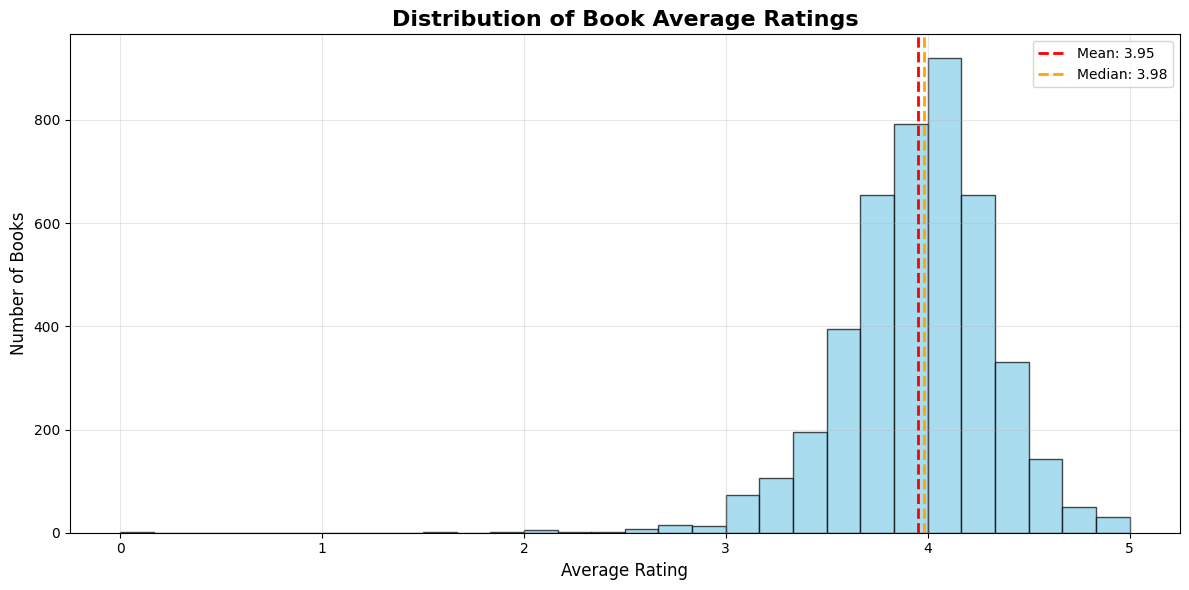

   ✅ Histogram saved: book_rating_histogram.png (4,392 books)

☁️ 2. Creating Word Cloud from Review Texts...


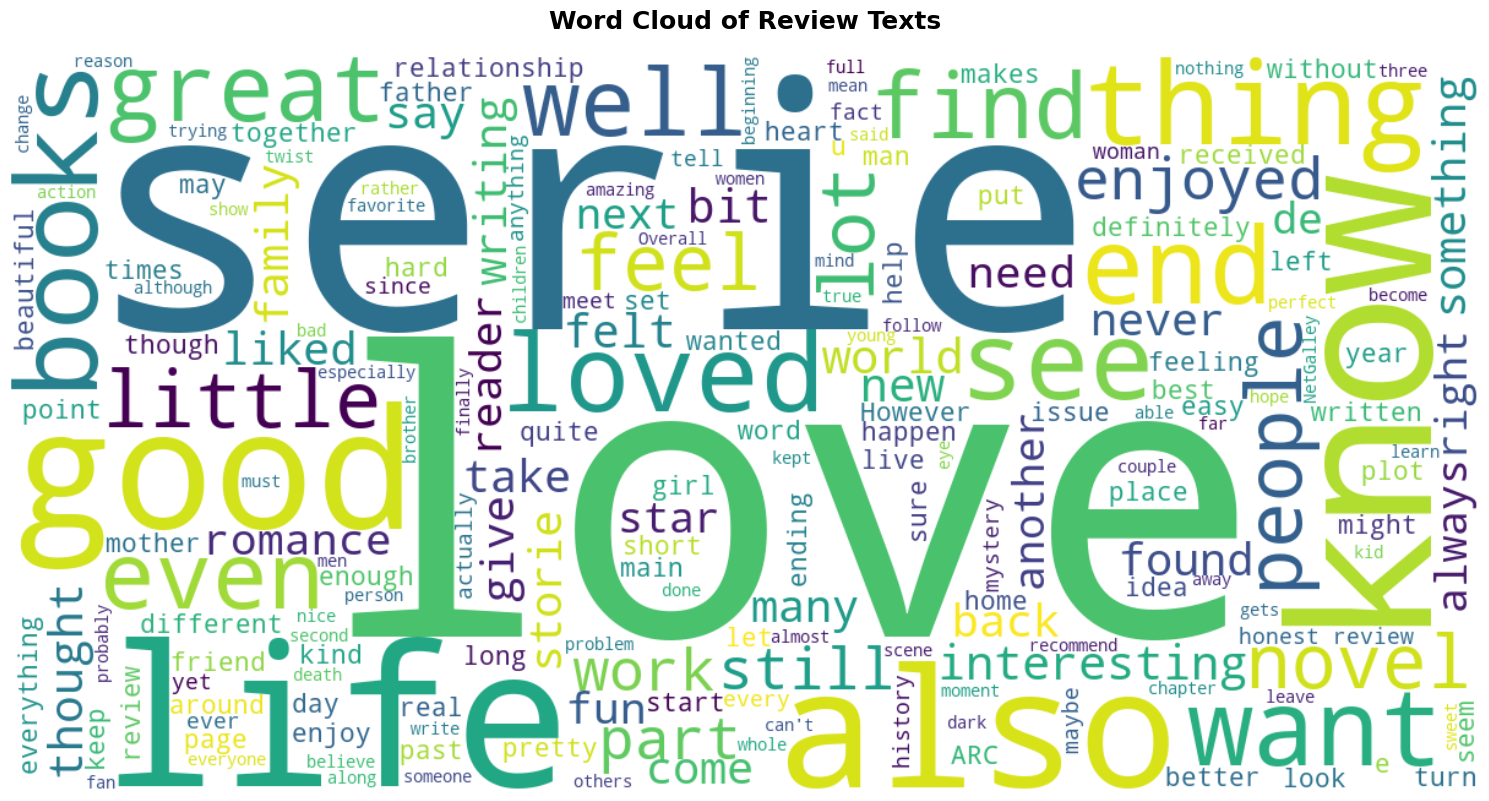

   ✅ Word cloud saved: review_text_wordcloud.png (4,935 reviews analyzed)

📚 3. Creating Top Genres Bar Chart...


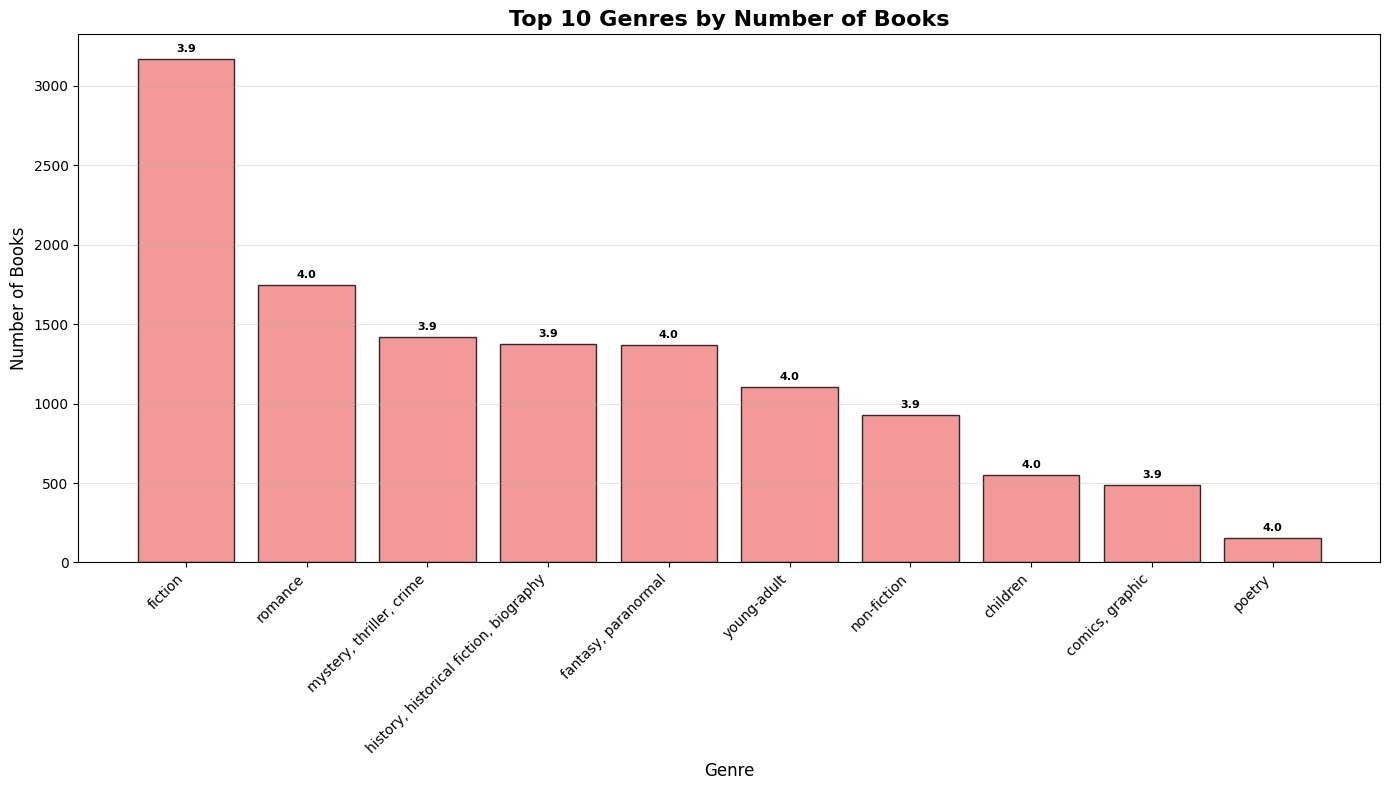

   ✅ Bar chart saved: top_genres_bar_chart.png (10 genres)

⭐ 4. Creating Rating Distribution by Top Genres...


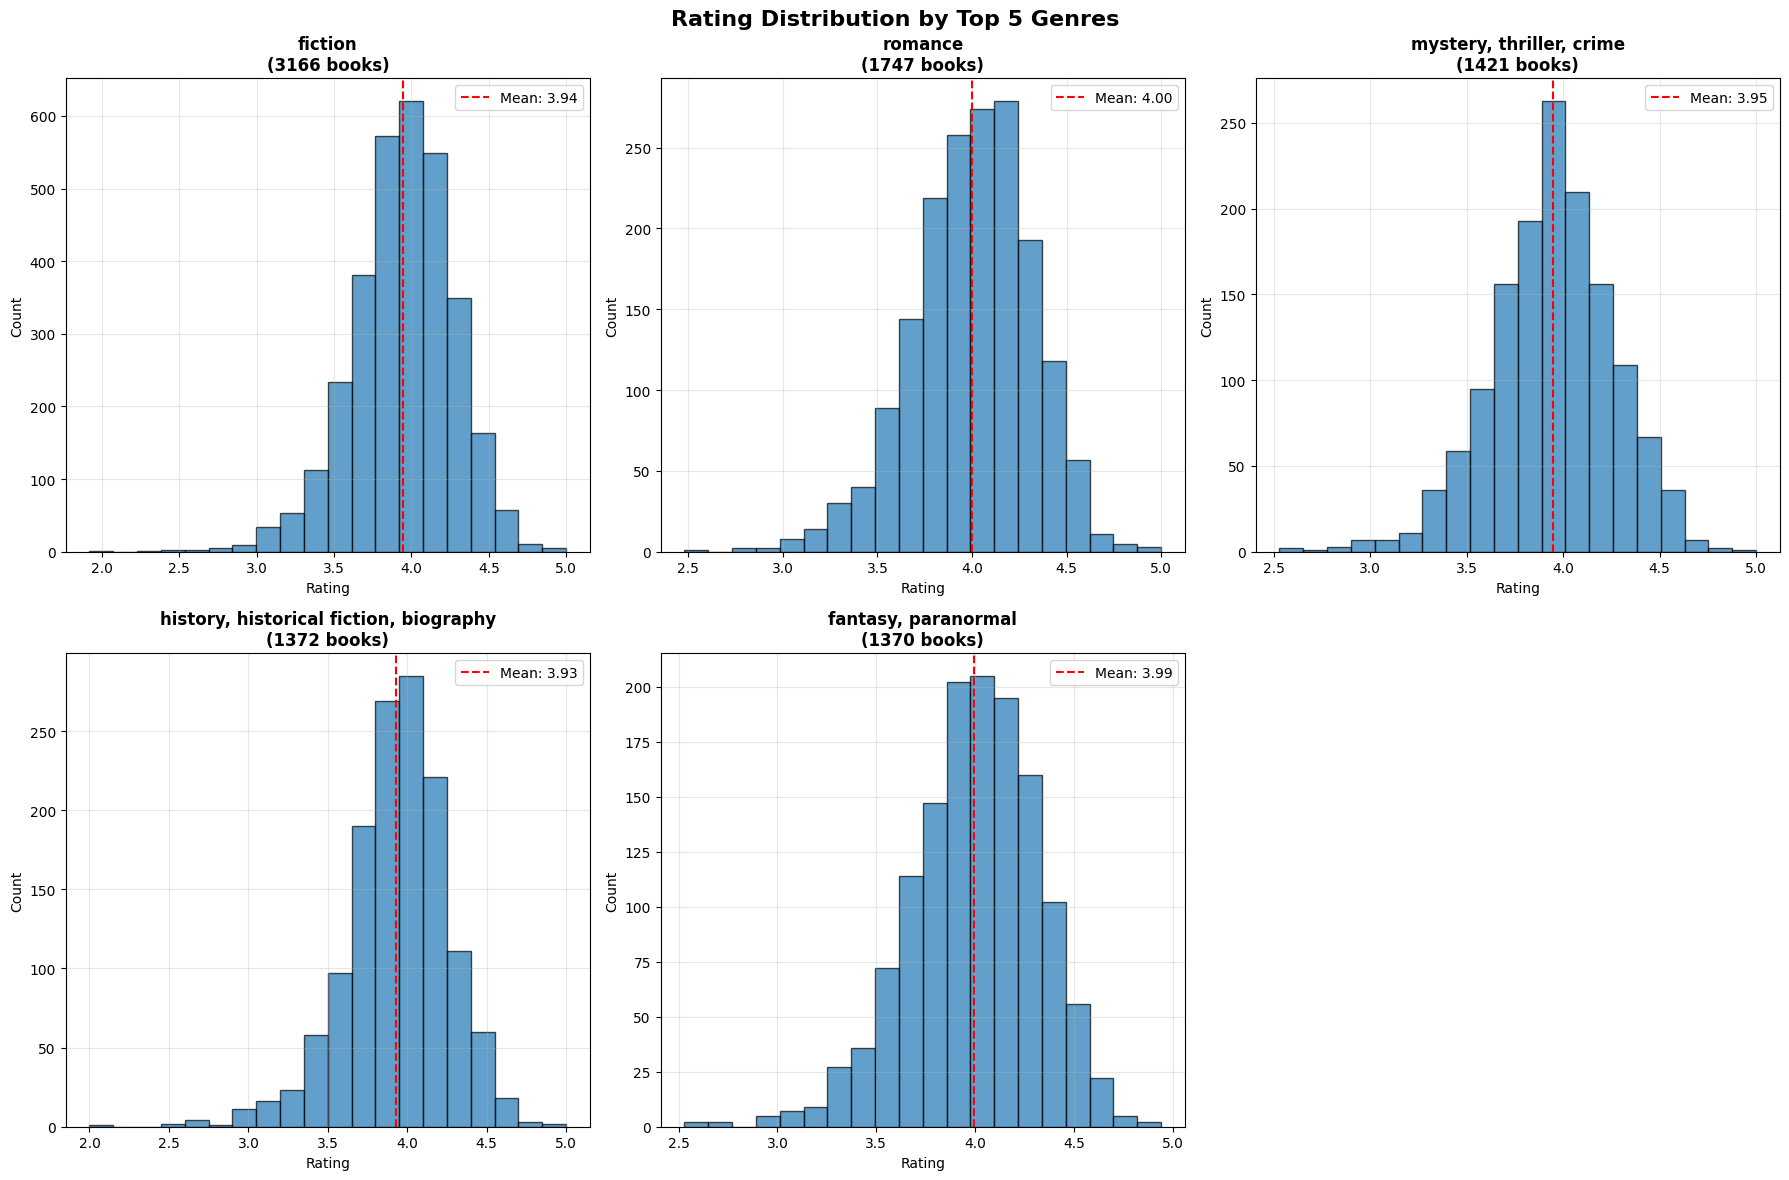

   ✅ Genre rating distribution saved: rating_distribution_by_genre.png

📋 5. Summary Statistics Table
--------------------------------------------------
   📊 FINAL SUMMARY:
      Total Books: 4,392
      Books with Genres: 4,282 (97.5%)
      Total Reviews: 174,087
      Reviews with Text: 173,996 (99.9%)
      Total Authors: 829,529

🔌 MongoDB connection closed
   📊 FINAL SUMMARY:
      Total Books: 4,392
      Books with Genres: 4,282 (97.5%)
      Total Reviews: 174,087
      Reviews with Text: 173,996 (99.9%)
      Total Authors: 829,529

🔌 MongoDB connection closed


In [7]:
# 📊 DATA VISUALIZATIONS - Charts, Word Clouds & Analysis
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import numpy as np
from collections import Counter

print("🎨 CREATING DATA VISUALIZATIONS")
print("=" * 60)

try:
    # Connect to MongoDB
    client = MongoClient(url)
    db = client["goodreads"]
    
    # Set up matplotlib for better plots
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 10
    
    # 1. HISTOGRAM: Distribution of Book Average Ratings
    print("📊 1. Creating Book Rating Distribution Histogram...")
    
    # Get book ratings (convert strings to floats)
    books_cursor = db.books.find({"average_rating": {"$exists": True, "$ne": None}}, 
                                {"average_rating": 1, "title": 1})
    
    ratings = []
    for book in books_cursor:
        try:
            rating = float(book["average_rating"])
            ratings.append(rating)
        except (ValueError, TypeError):
            continue
    
    if ratings:
        plt.figure(figsize=(12, 6))
        plt.hist(ratings, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
        plt.title("Distribution of Book Average Ratings", fontsize=16, fontweight='bold')
        plt.xlabel("Average Rating", fontsize=12)
        plt.ylabel("Number of Books", fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Add statistics text
        mean_rating = np.mean(ratings)
        median_rating = np.median(ratings)
        plt.axvline(mean_rating, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_rating:.2f}')
        plt.axvline(median_rating, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_rating:.2f}')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig("book_rating_histogram.png", dpi=300, bbox_inches='tight')
        plt.show()
        print(f"   ✅ Histogram saved: book_rating_histogram.png ({len(ratings):,} books)")
    else:
        print("   ❌ No valid rating data found for histogram")
    
    # 2. WORD CLOUD: Review Text Analysis
    print(f"\n☁️ 2. Creating Word Cloud from Review Texts...")
    
    # Get review texts (sample to avoid memory issues)
    review_texts = []
    reviews_cursor = db.reviews.find(
        {"review_text": {"$exists": True, "$ne": None, "$ne": ""}},
        {"review_text": 1}
    ).limit(5000)  # Limit for performance
    
    for review in reviews_cursor:
        text = review.get("review_text", "")
        if text and len(text) > 10:  # Filter out very short texts
            review_texts.append(text)
    
    if review_texts:
        # Combine all review texts
        combined_text = " ".join(review_texts)
        
        # Enhanced stopwords
        try:
            stop_words = set(stopwords.words('english'))
        except:
            stop_words = set()
        
        # Add book-specific stopwords
        stop_words.update(['book', 'read', 'reading', 'story', 'author', 'character', 'characters', 
                          'would', 'could', 'really', 'much', 'get', 'got', 'going', 'go', 'like',
                          'one', 'two', 'first', 'last', 'time', 'way', 'make', 'made', 'think'])
        
        # Create word cloud
        wordcloud = WordCloud(
            width=1200, 
            height=600, 
            background_color='white',
            stopwords=stop_words,
            min_font_size=10,
            max_words=200,
            relative_scaling=0.5,  
            colormap='viridis'
        ).generate(combined_text)
        
        plt.figure(figsize=(15, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title("Word Cloud of Review Texts", fontsize=18, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.savefig("review_text_wordcloud.png", dpi=300, bbox_inches='tight')
        plt.show()
        print(f"   ✅ Word cloud saved: review_text_wordcloud.png ({len(review_texts):,} reviews analyzed)")
    else:
        print("   ❌ No review text data found for word cloud")
    
    # 3. BAR CHART: Top Genres by Book Count
    print(f"\n📚 3. Creating Top Genres Bar Chart...")
    
    # Aggregate genre data
    genre_pipeline = [
        {"$unwind": "$genres"},
        {"$group": {
            "_id": "$genres",
            "book_count": {"$sum": 1},
            "avg_rating": {"$avg": {"$toDouble": "$average_rating"}}
        }},
        {"$sort": {"book_count": -1}},
        {"$limit": 15}
    ]
    
    genre_data = list(db.books.aggregate(genre_pipeline))
    
    if genre_data:
        # Prepare data for plotting
        genres = [item["_id"] for item in genre_data]
        counts = [item["book_count"] for item in genre_data]
        avg_ratings = [item.get("avg_rating", 0) for item in genre_data]
        
        # Create bar chart
        plt.figure(figsize=(14, 8))
        bars = plt.bar(range(len(genres)), counts, color='lightcoral', alpha=0.8, edgecolor='black')
        
        # Add average rating as text on bars
        for i, (bar, rating) in enumerate(zip(bars, avg_ratings)):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
                    f'{rating:.1f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
        
        plt.title("Top 10 Genres by Number of Books", fontsize=16, fontweight='bold')
        plt.xlabel("Genre", fontsize=12)
        plt.ylabel("Number of Books", fontsize=12)
        plt.xticks(range(len(genres)), genres, rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig("top_genres_bar_chart.png", dpi=300, bbox_inches='tight')
        plt.show()
        print(f"   ✅ Bar chart saved: top_genres_bar_chart.png ({len(genre_data)} genres)")
    else:
        print("   ❌ No genre data found for bar chart")
    
    # 4. BONUS: Rating Distribution by Genre (Top 5 Genres)
    print(f"\n⭐ 4. Creating Rating Distribution by Top Genres...")
    
    if genre_data and len(genre_data) >= 5:
        top_5_genres = [item["_id"] for item in genre_data[:5]]
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for i, genre in enumerate(top_5_genres):
            # Get books for this genre
            genre_books = list(db.books.find(
                {"genres": genre, "average_rating": {"$exists": True}},
                {"average_rating": 1}
            ))
            
            genre_ratings = []
            for book in genre_books:
                try:
                    rating = float(book["average_rating"])
                    genre_ratings.append(rating)
                except (ValueError, TypeError):
                    continue
            
            if genre_ratings:
                axes[i].hist(genre_ratings, bins=20, alpha=0.7, edgecolor='black')
                axes[i].set_title(f'{genre}\n({len(genre_ratings)} books)', fontweight='bold')
                axes[i].set_xlabel('Rating')
                axes[i].set_ylabel('Count')
                axes[i].grid(True, alpha=0.3)
                
                # Add mean line
                mean_rating = np.mean(genre_ratings)
                axes[i].axvline(mean_rating, color='red', linestyle='--', 
                               label=f'Mean: {mean_rating:.2f}')
                axes[i].legend()
        
        # Hide the last subplot if we have only 5 genres
        axes[5].axis('off')
        
        plt.suptitle('Rating Distribution by Top 5 Genres', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig("rating_distribution_by_genre.png", dpi=300, bbox_inches='tight')
        plt.show()
        print(f"   ✅ Genre rating distribution saved: rating_distribution_by_genre.png")
    
    # 5. SUMMARY STATISTICS TABLE
    print(f"\n📋 5. Summary Statistics Table")
    print("-" * 50)
    
    summary_stats = {
        'Collection': ['Books', 'Reviews', 'Authors'],
        'Total Count': [
            db.books.count_documents({}),
            db.reviews.count_documents({}),
            db.authors.count_documents({})
        ]
    }
    
    # Add more detailed stats
    books_with_genres = db.books.count_documents({"genres": {"$exists": True, "$ne": []}})
    reviews_with_text = db.reviews.count_documents({"review_text": {"$exists": True, "$ne": ""}})
    
    print(f"   📊 FINAL SUMMARY:")
    print(f"      Total Books: {summary_stats['Total Count'][0]:,}")
    print(f"      Books with Genres: {books_with_genres:,} ({books_with_genres/summary_stats['Total Count'][0]*100:.1f}%)")
    print(f"      Total Reviews: {summary_stats['Total Count'][1]:,}")
    print(f"      Reviews with Text: {reviews_with_text:,} ({reviews_with_text/summary_stats['Total Count'][1]*100:.1f}%)")
    print(f"      Total Authors: {summary_stats['Total Count'][2]:,}")

except Exception as e:
    print(f"❌ Error creating visualizations: {e}")
    import traceback
    traceback.print_exc()
    
finally:
    if 'client' in locals():
        client.close()
        print(f"\n🔌 MongoDB connection closed")



# More EDA

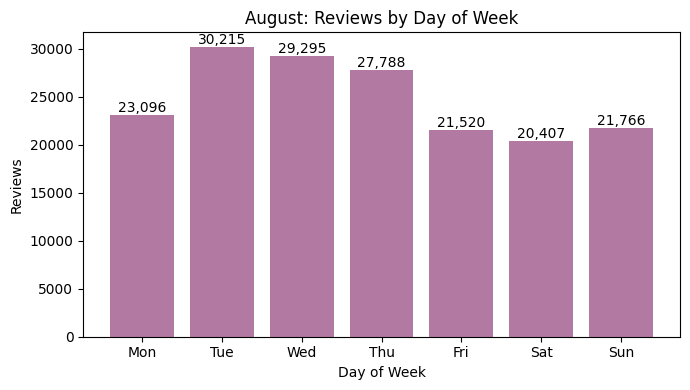

Saved figures/august_weekday_engagement.png


In [3]:
# August Cohort: Weekday engagement using string date field
# Requirements: `url` already set; matplotlib and pandas available
import os
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient

# Ensure output directory
os.makedirs('figures', exist_ok=True)

# Parameters
MONTH_NAME = 'Aug'  # Matches 'Fri Aug 25 ... 2017' string format

# Build pipeline for weekday engagement only
weekday_pipeline = [
    { "$match": { "date_added": { "$type": "string" }, "date_added": { "$regex": f"\\b{MONTH_NAME}\\b" } } },
    { "$addFields": {
        "_tmp": { "$split": ["$date_added", " "] }
    }},
    { "$addFields": {
        "day": { "$toInt": { "$arrayElemAt": ["$_tmp", 2] } },
        "year": { "$toInt": { "$arrayElemAt": ["$_tmp", 5] } },
        "date": { "$dateFromParts": { "year": { "$toInt": { "$arrayElemAt": ["$_tmp", 5] } }, "month": 8, "day": { "$toInt": { "$arrayElemAt": ["$_tmp", 2] } } } }
    }},
    { "$group": {
        "_id": { "$isoDayOfWeek": "$date" },
        "reviews": { "$sum": 1 },
        "avgRating": { "$avg": "$rating" }
    }},
    { "$project": {
        "_id": 0,
        "dayOfWeek": {
            "$let": {
                "vars": { "names": [None, "Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"] },
                "in": { "$arrayElemAt": ["$$names", "$_id"] }
            }
        },
        "reviews": 1,
        "avgRating": { "$round": ["$avgRating", 2] }
    }},
    { "$sort": { "reviews": -1 } }
]

# Run with a fresh client
if 'url' not in globals() or not isinstance(url, str) or not url:
    raise RuntimeError("MongoDB URL `url` is not defined. Please run the credentials cell above.")

with MongoClient(url) as local_client:
    db = local_client['goodreads']
    reviews = db['reviews']

    weekday_docs = list(reviews.aggregate(weekday_pipeline))

# Convert to DataFrame
if weekday_docs:
    df_weekday = pd.DataFrame(weekday_docs)
else:
    df_weekday = pd.DataFrame(columns=['dayOfWeek','reviews','avgRating'])

# Plot weekday bar chart
if not df_weekday.empty:
    order = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
    df_weekday['dayOfWeek'] = pd.Categorical(df_weekday['dayOfWeek'], categories=order, ordered=True)
    df_weekday = df_weekday.sort_values('dayOfWeek')

    fig, ax = plt.subplots(figsize=(7,4))
    bars = ax.bar(df_weekday['dayOfWeek'], df_weekday['reviews'], color='#B279A2')
    ax.set_xlabel('Day of Week')
    ax.set_ylabel('Reviews')
    ax.set_title('August: Reviews by Day of Week')
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x()+b.get_width()/2, h, f'{int(h):,}', ha='center', va='bottom')
    fig.tight_layout()
    out_path2 = 'figures/august_weekday_engagement.png'
    plt.savefig(out_path2, dpi=150)
    plt.show()
    print(f'Saved {out_path2}')
else:
    print('No August weekday data found (string-parsed).')

# 📖 Book Title Length vs Rating Analysis

Investigating whether longer book titles correlate with higher ratings. This analysis explores if title length indicates book complexity, genre, or quality factors that influence reader satisfaction.

In [19]:
from pymongo import MongoClient # import mongo client to connect
import json # import json to load credentials
import urllib.parse

# load credentials from json file
with open('credentials_mongodb.json') as f:
    login = json.load(f)

# assign credentials to variables
username = login['username']
password = urllib.parse.quote(login['password'])
host = login['host']
url = "mongodb+srv://{}:{}@{}/?retryWrites=true&w=majority".format(username, password, host)

# connect to the database
client = MongoClient(url)

In [14]:
# 📊 BOOK TITLE LENGTH vs RATING ANALYSIS - Data Preparation & Correlation Tests
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from pymongo import MongoClient

print("🔍 ANALYZING BOOK TITLE LENGTH vs RATING CORRELATION")
print("=" * 70)

try:
    # Connect to MongoDB (reuse existing url variable from credentials cell)
    client = MongoClient(url)
    db = client['goodreads']
    books_col = db['books']
    
    print("✅ Connected to MongoDB - goodreads.books collection")
    
    # STEP 1: Load book data with title and rating
    print("\n📚 STEP 1: Loading book data...")
    
    # Query books with both title and average_rating present
    books_cursor = books_col.find(
        {
            "title": {"$exists": True, "$ne": None, "$ne": ""},
            "average_rating": {"$exists": True, "$ne": None}
        },
        {"title": 1, "average_rating": 1, "genres": 1, "_id": 0}
    )
    
    books_data = list(books_cursor)
    print(f"   Retrieved {len(books_data):,} books with title and rating")
    
    if not books_data:
        raise ValueError("No books found with both title and rating fields")
    
    # Convert to DataFrame
    df = pd.DataFrame(books_data)
    
    # STEP 2: Feature Engineering - Title Length Metrics
    print("\n🔧 STEP 2: Computing title length features...")
    
    # Character length (including spaces and punctuation)
    df['title_len_chars'] = df['title'].astype(str).str.len()
    
    # Word count (split on whitespace)
    df['title_len_words'] = df['title'].astype(str).str.split().apply(len)
    
    # Letter count only (excluding spaces, numbers, punctuation)
    df['title_len_letters'] = df['title'].astype(str).str.replace(r'[^a-zA-Z]', '', regex=True).str.len()
    
    # Coerce rating to numeric (handle both string and numeric types)
    df['rating_numeric'] = pd.to_numeric(df['average_rating'], errors='coerce')
    
    # STEP 3: Data Cleaning
    print("\n🧹 STEP 3: Cleaning data...")
    print(f"   Before cleaning: {len(df):,} rows")
    
    # Remove rows with missing or invalid ratings
    df_clean = df.dropna(subset=['rating_numeric']).copy()
    
    # Remove extreme outliers in title length (keep 99th percentile)
    char_99 = df_clean['title_len_chars'].quantile(0.99)
    df_clean = df_clean[df_clean['title_len_chars'] <= char_99]
    
    # Remove zero-length titles
    df_clean = df_clean[df_clean['title_len_chars'] > 0]
    
    print(f"   After cleaning: {len(df_clean):,} rows")
    print(f"   Removed: {len(df) - len(df_clean):,} rows ({(len(df) - len(df_clean))/len(df)*100:.1f}%)")
    
    # STEP 4: Descriptive Statistics
    print("\n📊 STEP 4: Descriptive statistics")
    print("-" * 70)
    
    stats_summary = pd.DataFrame({
        'Metric': ['Title Length (chars)', 'Title Length (words)', 'Title Length (letters)', 'Rating'],
        'Mean': [
            df_clean['title_len_chars'].mean(),
            df_clean['title_len_words'].mean(),
            df_clean['title_len_letters'].mean(),
            df_clean['rating_numeric'].mean()
        ],
        'Median': [
            df_clean['title_len_chars'].median(),
            df_clean['title_len_words'].median(),
            df_clean['title_len_letters'].median(),
            df_clean['rating_numeric'].median()
        ],
        'Std Dev': [
            df_clean['title_len_chars'].std(),
            df_clean['title_len_words'].std(),
            df_clean['title_len_letters'].std(),
            df_clean['rating_numeric'].std()
        ],
        'Min': [
            df_clean['title_len_chars'].min(),
            df_clean['title_len_words'].min(),
            df_clean['title_len_letters'].min(),
            df_clean['rating_numeric'].min()
        ],
        'Max': [
            df_clean['title_len_chars'].max(),
            df_clean['title_len_words'].max(),
            df_clean['title_len_letters'].max(),
            df_clean['rating_numeric'].max()
        ]
    })
    
    # Format numbers for display
    for col in ['Mean', 'Median', 'Std Dev']:
        stats_summary[col] = stats_summary[col].apply(lambda x: f"{x:.2f}")
    for col in ['Min', 'Max']:
        stats_summary[col] = stats_summary[col].apply(lambda x: f"{x:.1f}")
    
    print(stats_summary.to_string(index=False))
    
    # STEP 5: Correlation Analysis
    print("\n📈 STEP 5: Correlation tests (Title Length vs Rating)")
    print("-" * 70)
    
    # Prepare data for correlation (drop any remaining NaN)
    x_chars = df_clean['title_len_chars'].values
    x_words = df_clean['title_len_words'].values
    y_rating = df_clean['rating_numeric'].values
    
    n_samples = len(df_clean)
    
    # A) Character length vs Rating
    pearson_r_chars, pearson_p_chars = pearsonr(x_chars, y_rating)
    spearman_r_chars, spearman_p_chars = spearmanr(x_chars, y_rating)
    
    print("📏 A) Title Length (characters) vs Rating:")
    print(f"   Sample size: {n_samples:,}")
    print(f"   Pearson correlation:  r = {pearson_r_chars:+.4f}, p-value = {pearson_p_chars:.4e}")
    print(f"   Spearman correlation: ρ = {spearman_r_chars:+.4f}, p-value = {spearman_p_chars:.4e}")
    
    # Interpretation
    if abs(pearson_r_chars) < 0.1:
        strength = "negligible"
    elif abs(pearson_r_chars) < 0.3:
        strength = "weak"
    elif abs(pearson_r_chars) < 0.5:
        strength = "moderate"
    else:
        strength = "strong"
    
    direction = "positive" if pearson_r_chars > 0 else "negative"
    significance = "statistically significant" if pearson_p_chars < 0.01 else "not significant"
    
    print(f"   Interpretation: {strength.capitalize()} {direction} correlation, {significance}")
    
    # B) Word count vs Rating
    pearson_r_words, pearson_p_words = pearsonr(x_words, y_rating)
    spearman_r_words, spearman_p_words = spearmanr(x_words, y_rating)
    
    print("\n📝 B) Title Length (words) vs Rating:")
    print(f"   Sample size: {n_samples:,}")
    print(f"   Pearson correlation:  r = {pearson_r_words:+.4f}, p-value = {pearson_p_words:.4e}")
    print(f"   Spearman correlation: ρ = {spearman_r_words:+.4f}, p-value = {spearman_p_words:.4e}")
    
    # STEP 6: Segmented Analysis by Title Length Bins
    print("\n📦 STEP 6: Binned analysis (mean rating by title-length category)")
    print("-" * 70)
    
    # Create bins for character length
    df_clean['len_category'] = pd.cut(
        df_clean['title_len_chars'],
        bins=[0, 20, 40, 60, 80, 200],
        labels=['Very Short (1-20)', 'Short (21-40)', 'Medium (41-60)', 'Long (61-80)', 'Very Long (80+)']
    )
    
    binned_stats = df_clean.groupby('len_category', observed=True).agg({
        'rating_numeric': ['mean', 'median', 'std', 'count']
    }).round(3)
    
    binned_stats.columns = ['Mean Rating', 'Median Rating', 'Std Dev', 'Count']
    binned_stats = binned_stats.reset_index()
    binned_stats.columns = ['Title Length Category', 'Mean Rating', 'Median Rating', 'Std Dev', 'Count']
    
    print(binned_stats.to_string(index=False))
    
    # STEP 7: Sample Books by Length Category
    print("\n📚 STEP 7: Sample books from each length category")
    print("-" * 70)
    
    for category in df_clean['len_category'].cat.categories:
        sample_books = df_clean[df_clean['len_category'] == category].nlargest(2, 'rating_numeric')
        if not sample_books.empty:
            print(f"\n{category}:")
            for idx, row in sample_books.iterrows():
                title_display = row['title'][:60] + '...' if len(row['title']) > 60 else row['title']
                print(f"   • \"{title_display}\" (Rating: {row['rating_numeric']:.2f}, {row['title_len_chars']} chars)")
    
    # Save cleaned data for visualization
    print(f"\n✅ Data preparation complete - {len(df_clean):,} books ready for visualization")
    
    # Store in global scope for next cell
    title_rating_df = df_clean.copy()
    
except Exception as e:
    print(f"❌ Error during analysis: {e}")
    import traceback
    traceback.print_exc()
finally:
    if 'client' in locals():
        client.close()
        print("\n🔌 MongoDB connection closed")

🔍 ANALYZING BOOK TITLE LENGTH vs RATING CORRELATION
✅ Connected to MongoDB - goodreads.books collection

📚 STEP 1: Loading book data...
   Retrieved 4,392 books with title and rating

🔧 STEP 2: Computing title length features...

🧹 STEP 3: Cleaning data...
   Before cleaning: 4,392 rows
   After cleaning: 4,348 rows
   Removed: 44 rows (1.0%)

📊 STEP 4: Descriptive statistics
----------------------------------------------------------------------
                Metric  Mean Median Std Dev Min   Max
  Title Length (chars) 31.12  28.00   18.65 1.0 101.0
  Title Length (words)  5.34   5.00    3.18 1.0  20.0
Title Length (letters) 23.85  21.00   14.99 0.0  84.0
                Rating  3.95   3.98    0.38 0.0   5.0

📈 STEP 5: Correlation tests (Title Length vs Rating)
----------------------------------------------------------------------
📏 A) Title Length (characters) vs Rating:
   Sample size: 4,348
   Pearson correlation:  r = +0.1504, p-value = 2.0638e-23
   Spearman correlation: ρ = +0.

🎨 CREATING TITLE LENGTH vs RATING VISUALIZATIONS
✅ Using 4,348 books for visualization

📊 Creating scatter plot: Title Length (chars) vs Rating...


🎨 CREATING TITLE LENGTH vs RATING VISUALIZATIONS
✅ Using 4,348 books for visualization

📊 Creating scatter plot: Title Length (chars) vs Rating...


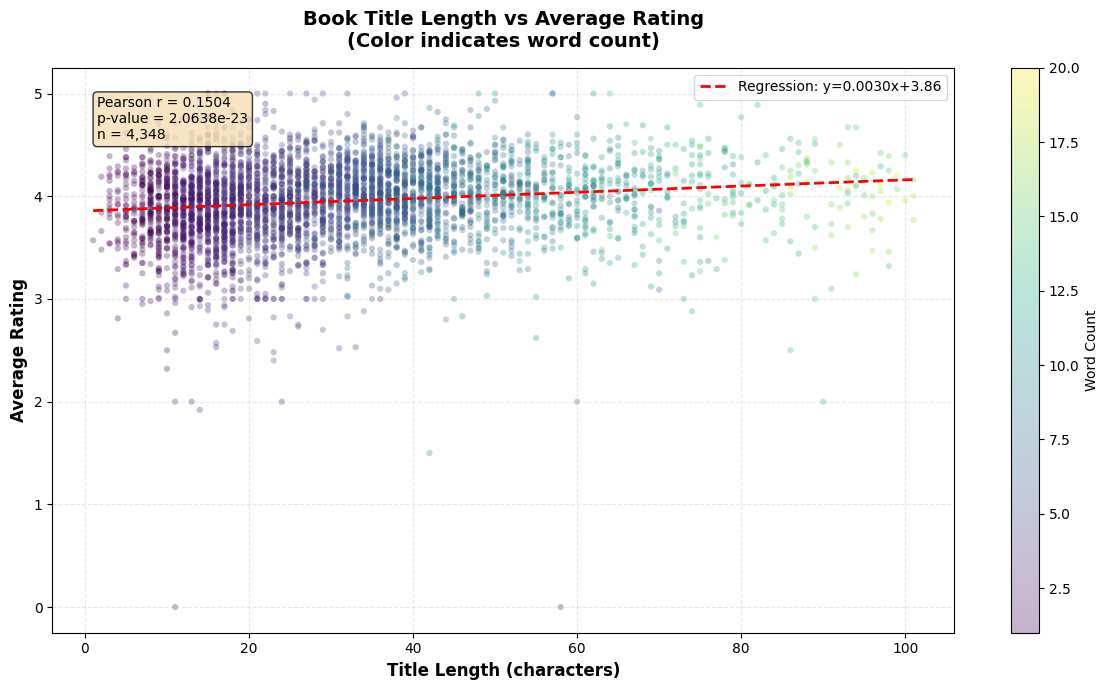

🎨 CREATING TITLE LENGTH vs RATING VISUALIZATIONS
✅ Using 4,348 books for visualization

📊 Creating scatter plot: Title Length (chars) vs Rating...


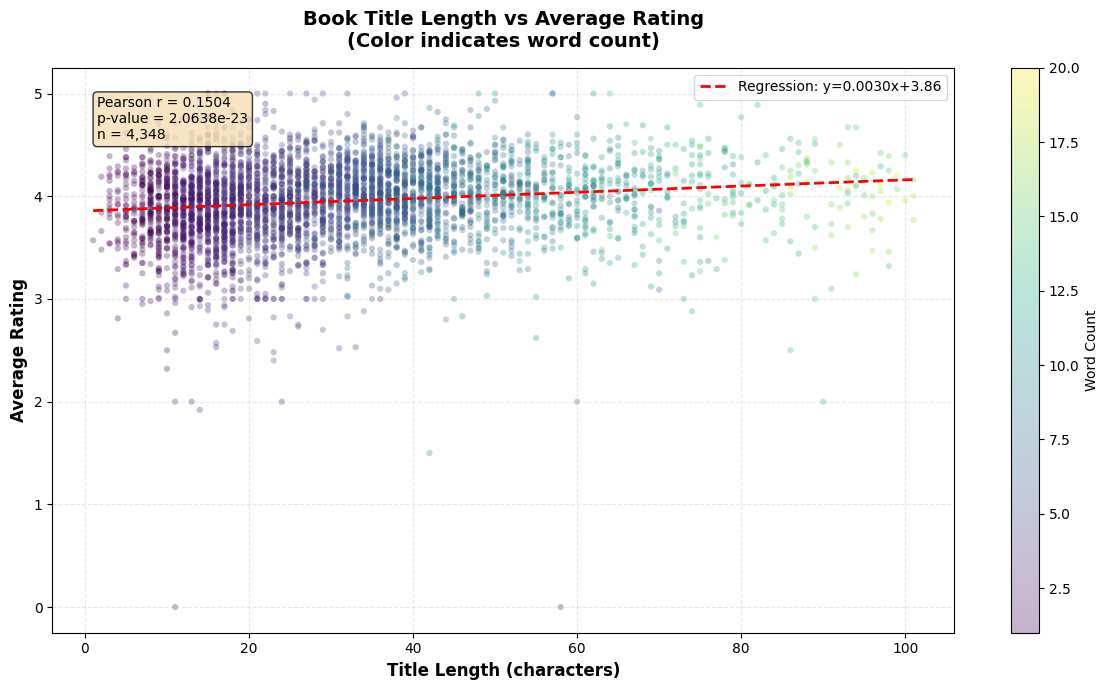

   ✅ Saved: figures/title_length_vs_rating_scatter.png

📊 Creating bar chart: Mean rating by title-length category...


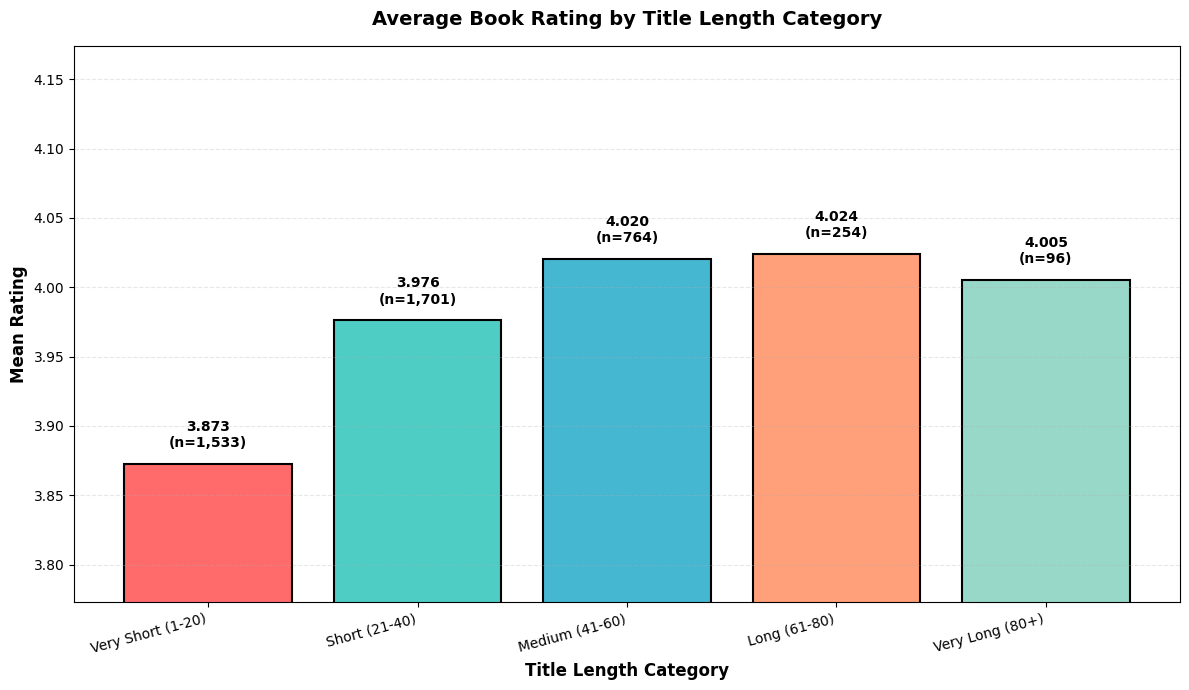

🎨 CREATING TITLE LENGTH vs RATING VISUALIZATIONS
✅ Using 4,348 books for visualization

📊 Creating scatter plot: Title Length (chars) vs Rating...


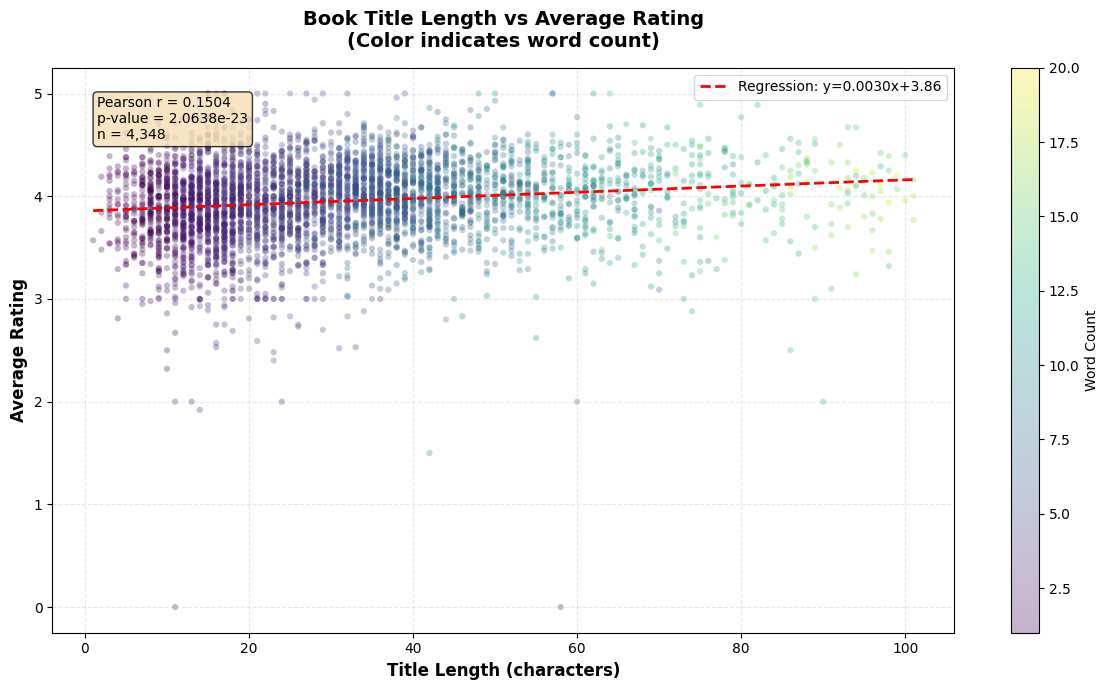

   ✅ Saved: figures/title_length_vs_rating_scatter.png

📊 Creating bar chart: Mean rating by title-length category...


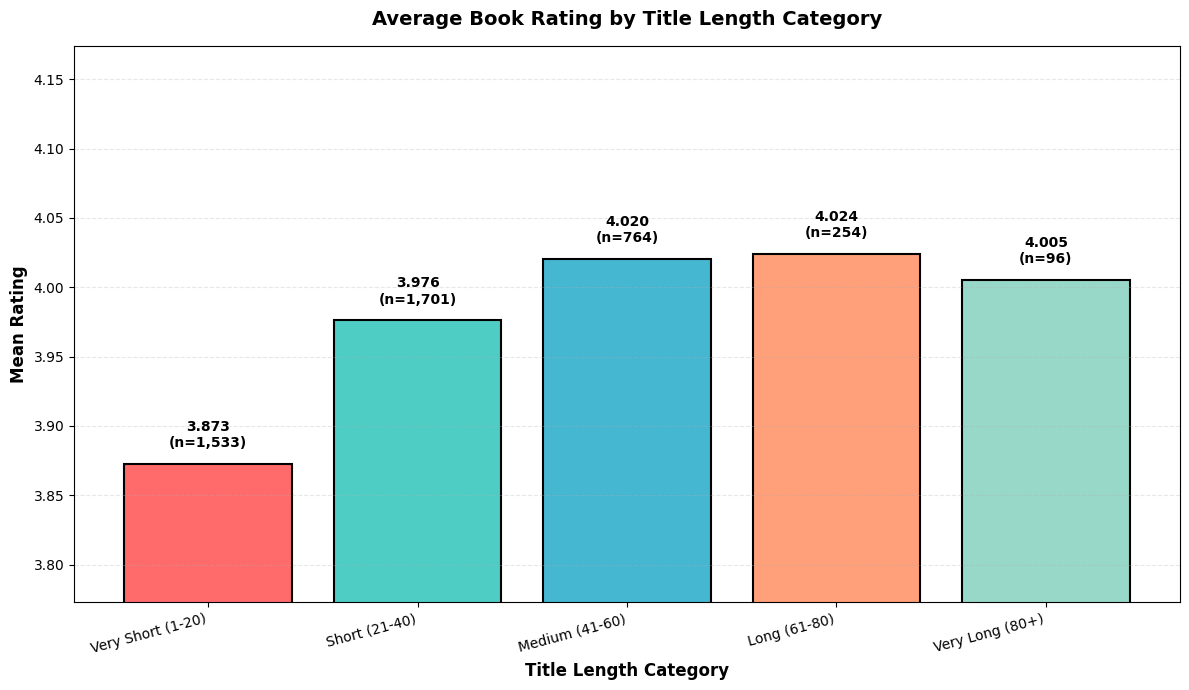

   ✅ Saved: figures/title_length_category_ratings.png

📊 Creating distribution plots: Title length and rating distributions...


🎨 CREATING TITLE LENGTH vs RATING VISUALIZATIONS
✅ Using 4,348 books for visualization

📊 Creating scatter plot: Title Length (chars) vs Rating...


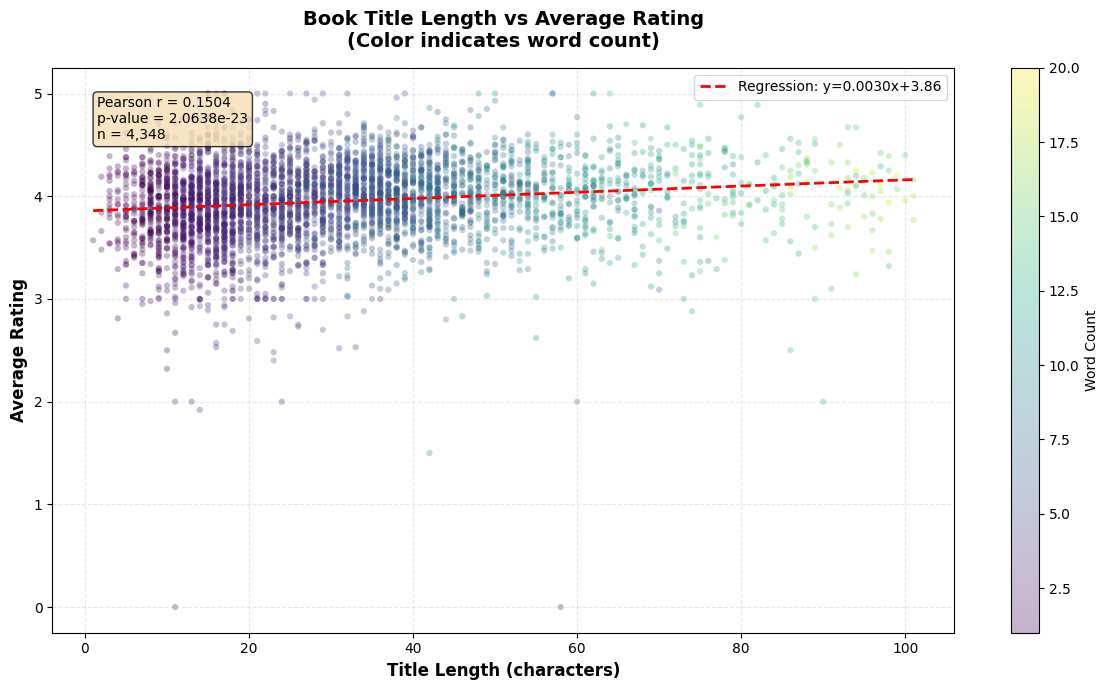

   ✅ Saved: figures/title_length_vs_rating_scatter.png

📊 Creating bar chart: Mean rating by title-length category...


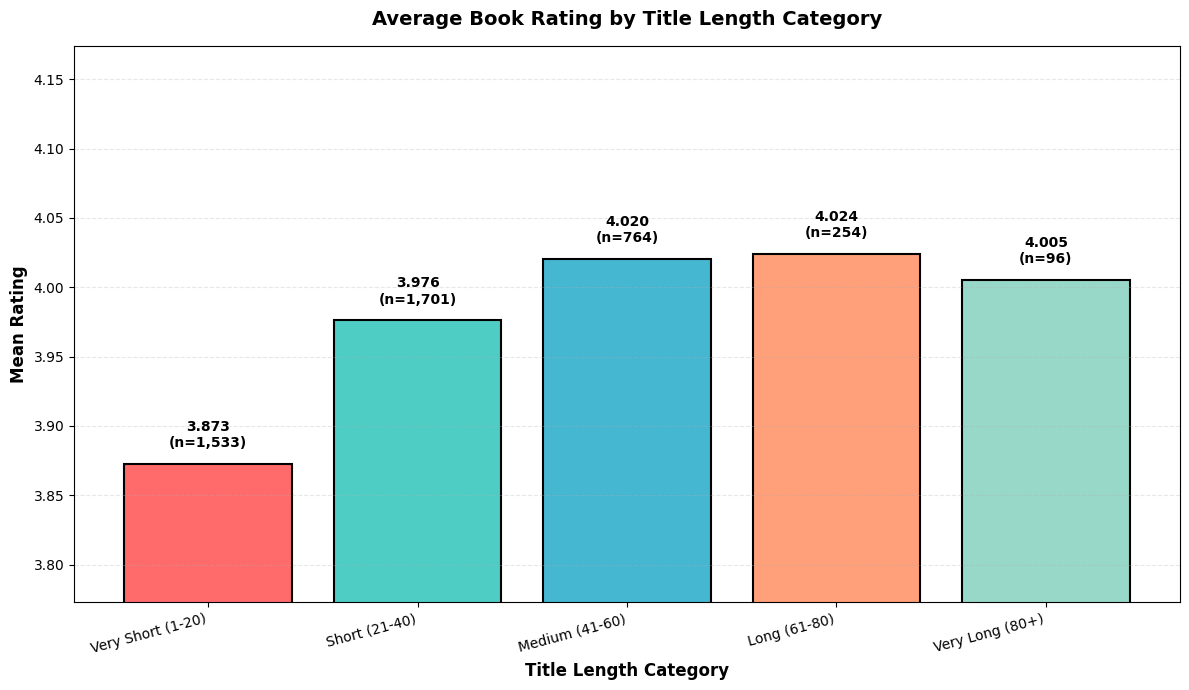

   ✅ Saved: figures/title_length_category_ratings.png

📊 Creating distribution plots: Title length and rating distributions...


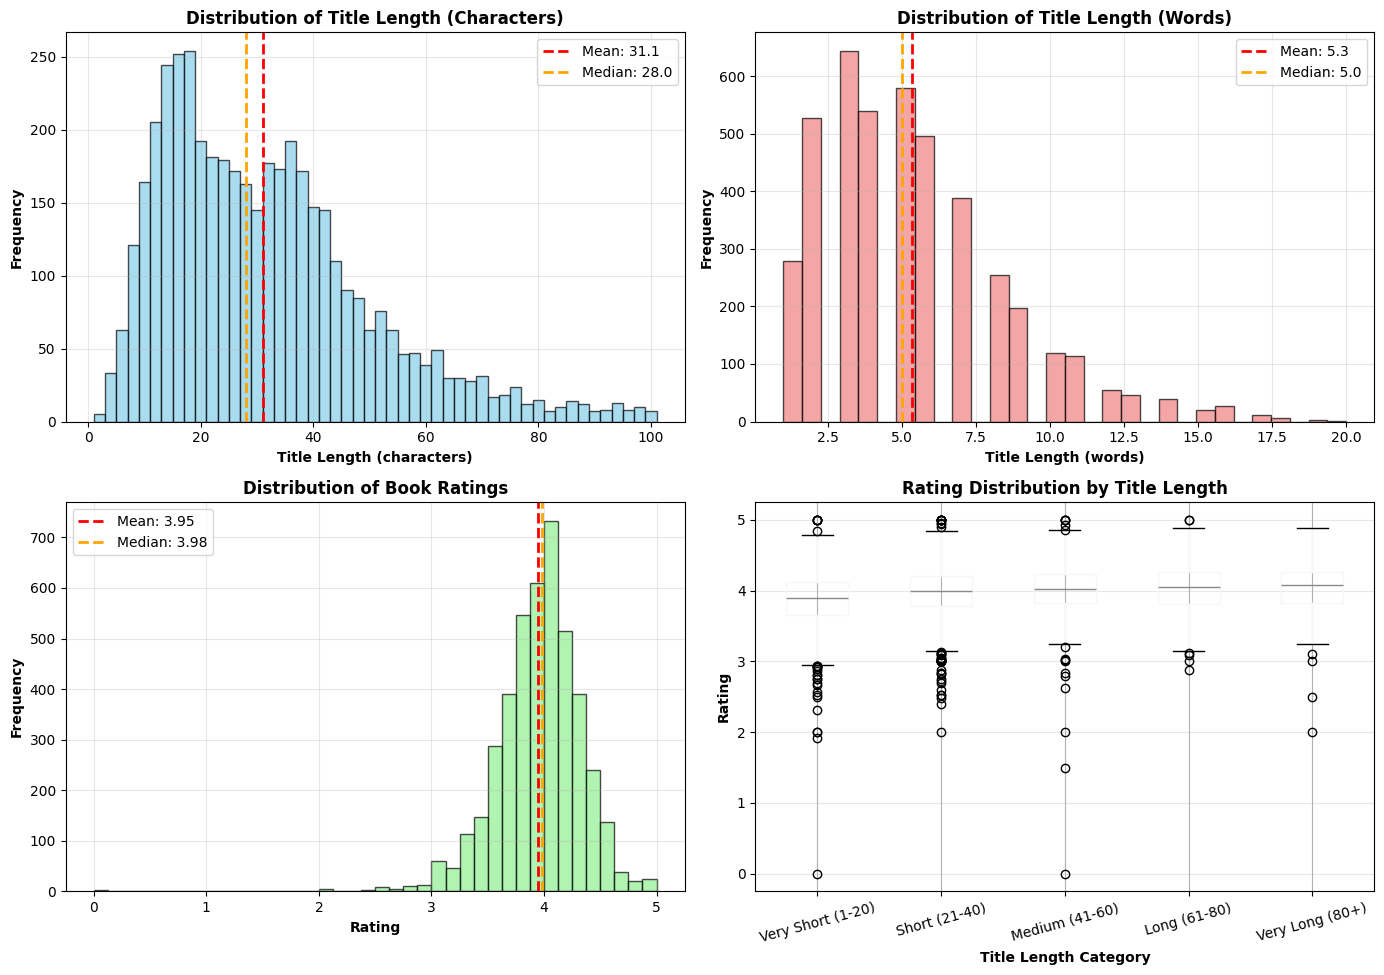

🎨 CREATING TITLE LENGTH vs RATING VISUALIZATIONS
✅ Using 4,348 books for visualization

📊 Creating scatter plot: Title Length (chars) vs Rating...


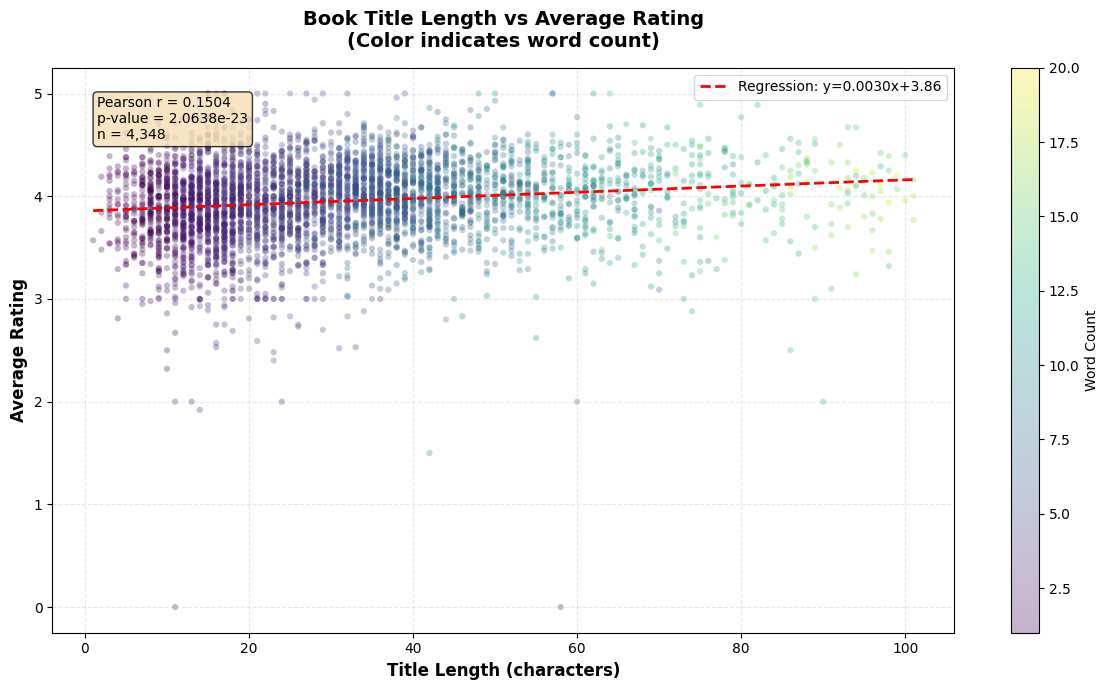

   ✅ Saved: figures/title_length_vs_rating_scatter.png

📊 Creating bar chart: Mean rating by title-length category...


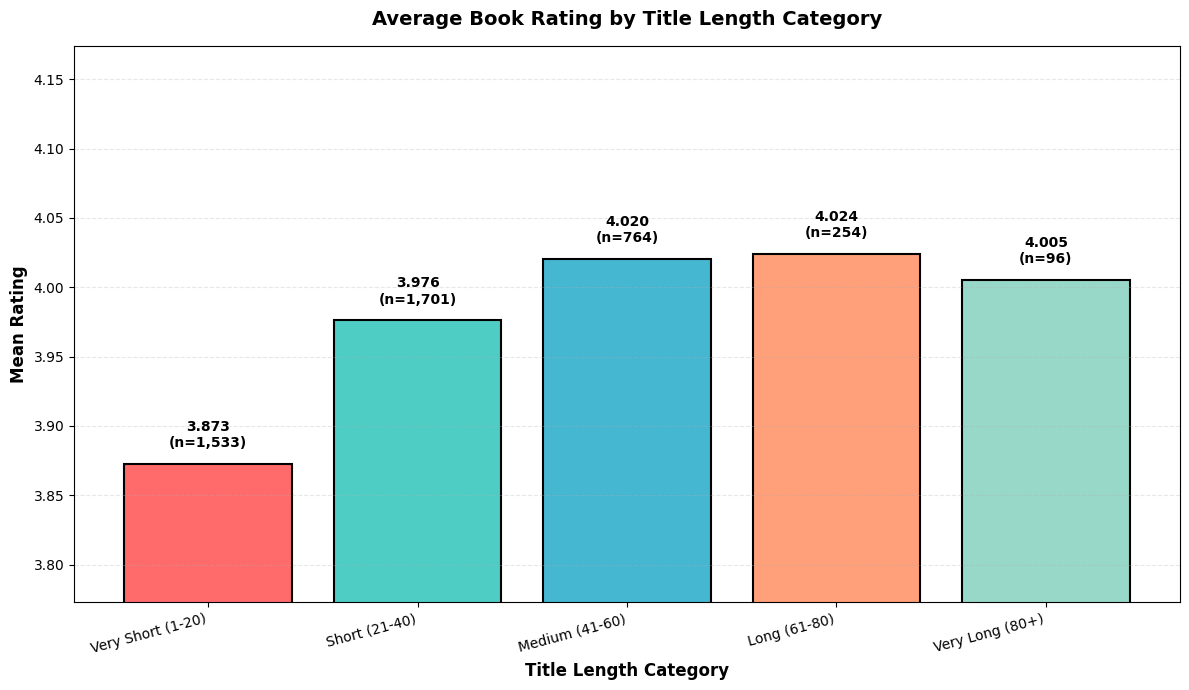

   ✅ Saved: figures/title_length_category_ratings.png

📊 Creating distribution plots: Title length and rating distributions...


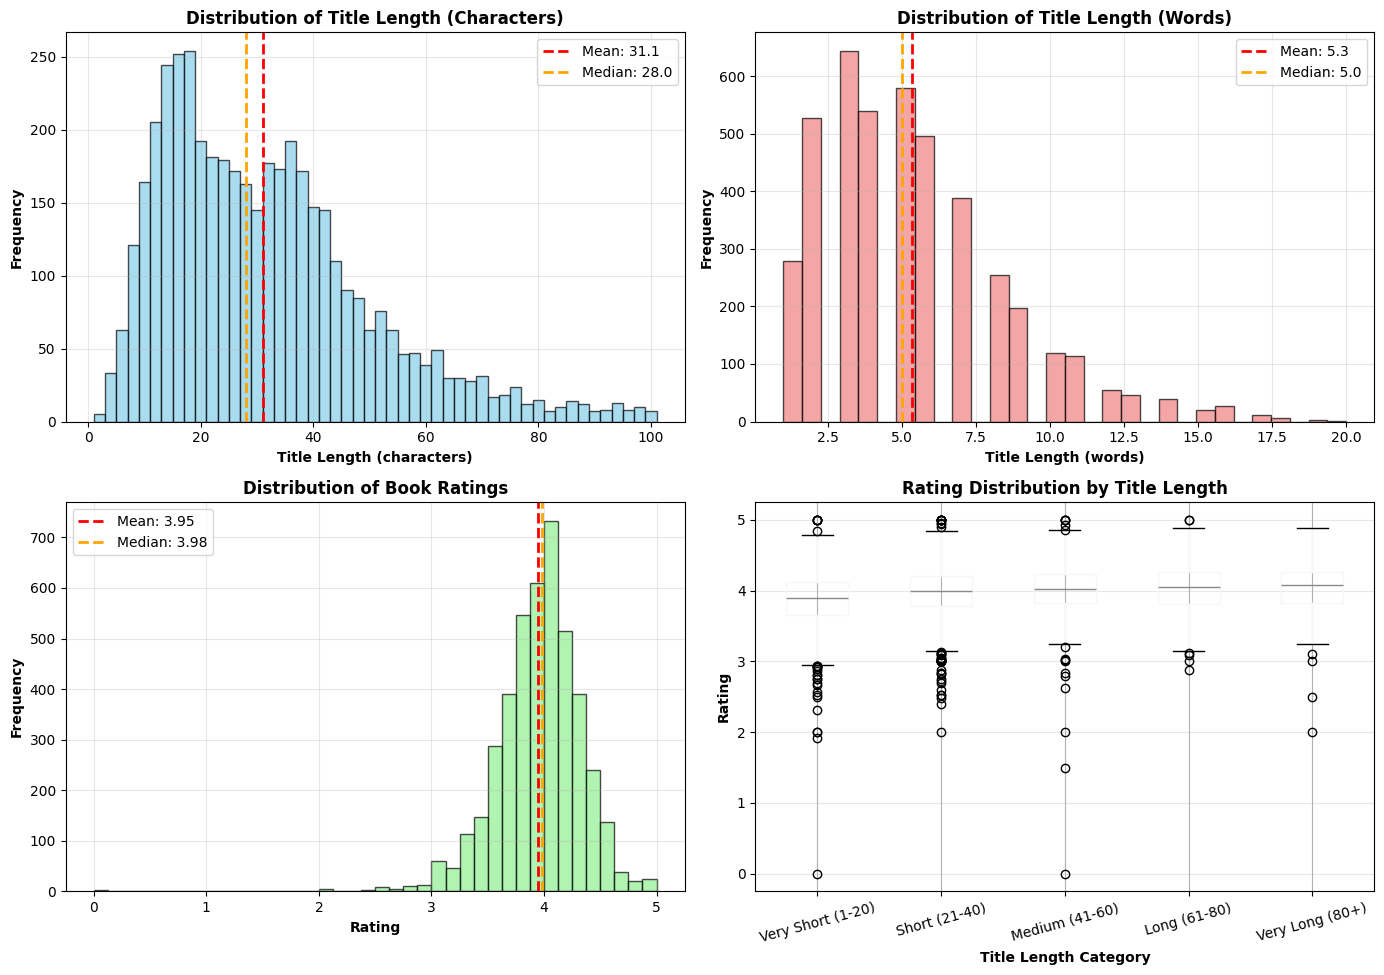

   ✅ Saved: figures/title_length_distributions.png

📊 Creating hexbin density plot...


🎨 CREATING TITLE LENGTH vs RATING VISUALIZATIONS
✅ Using 4,348 books for visualization

📊 Creating scatter plot: Title Length (chars) vs Rating...


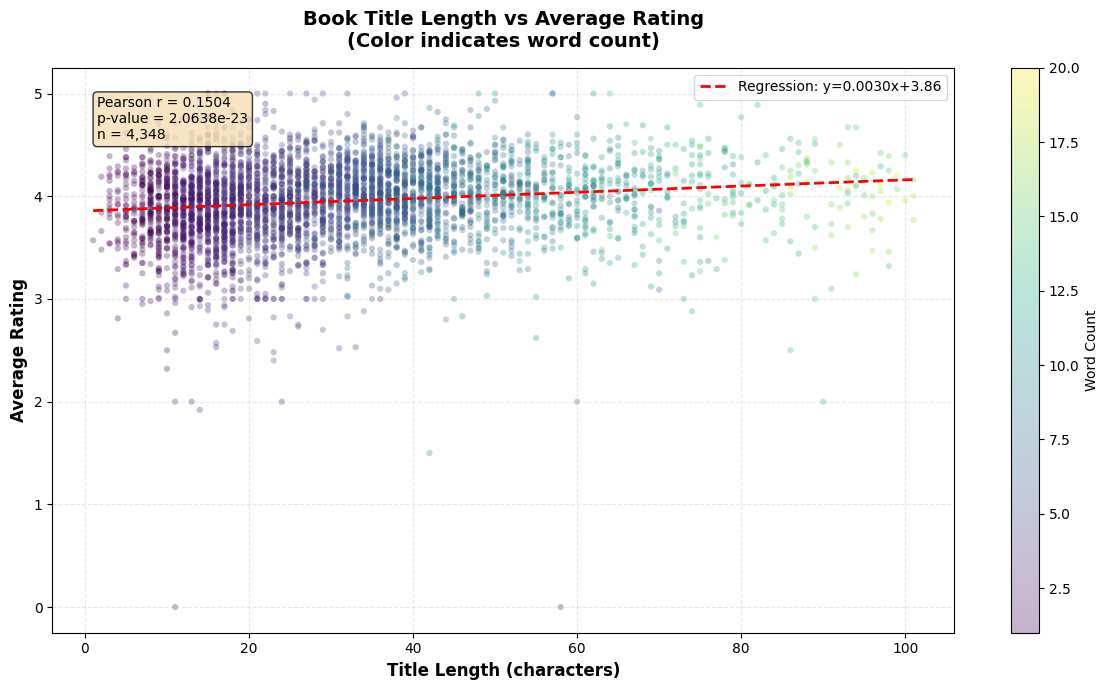

   ✅ Saved: figures/title_length_vs_rating_scatter.png

📊 Creating bar chart: Mean rating by title-length category...


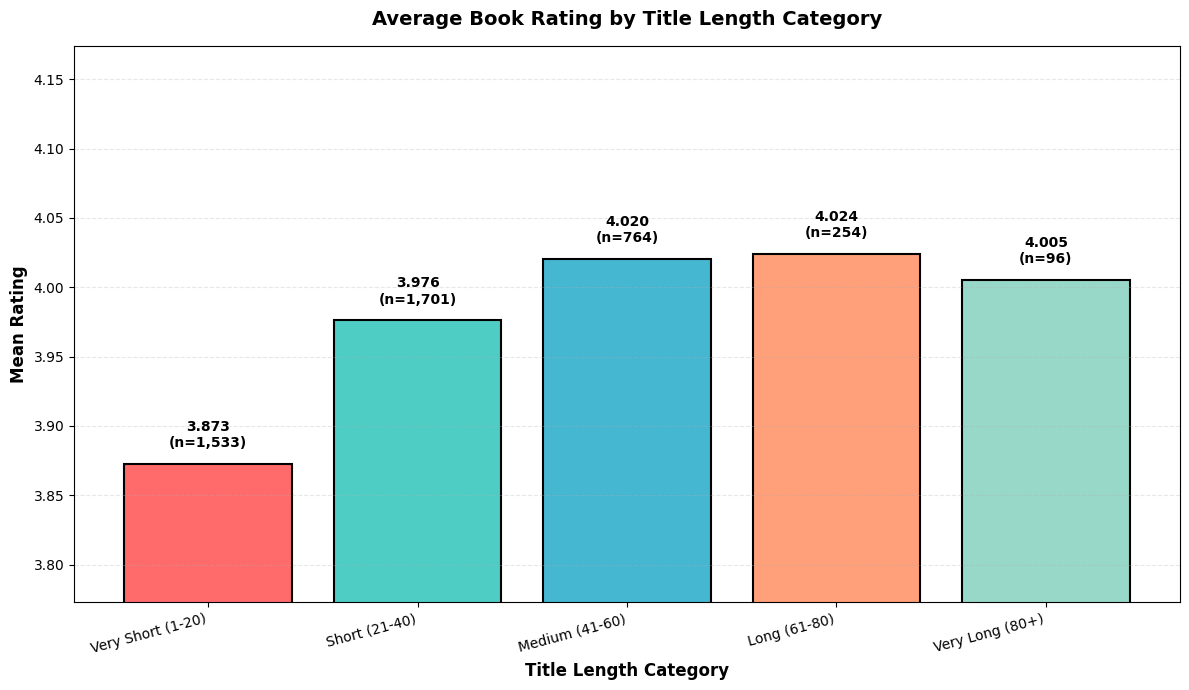

   ✅ Saved: figures/title_length_category_ratings.png

📊 Creating distribution plots: Title length and rating distributions...


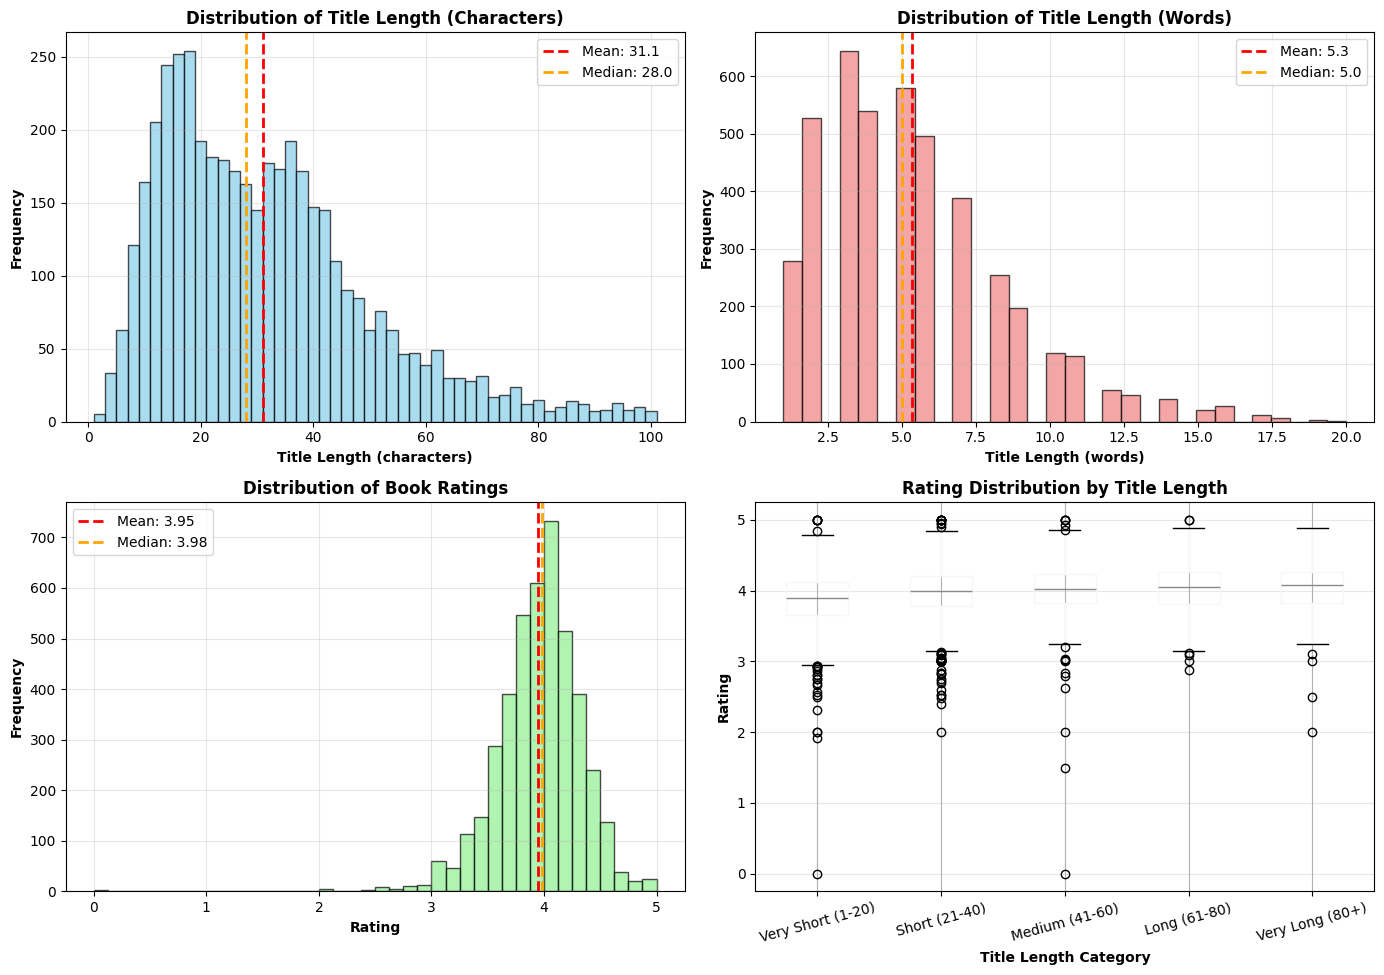

   ✅ Saved: figures/title_length_distributions.png

📊 Creating hexbin density plot...


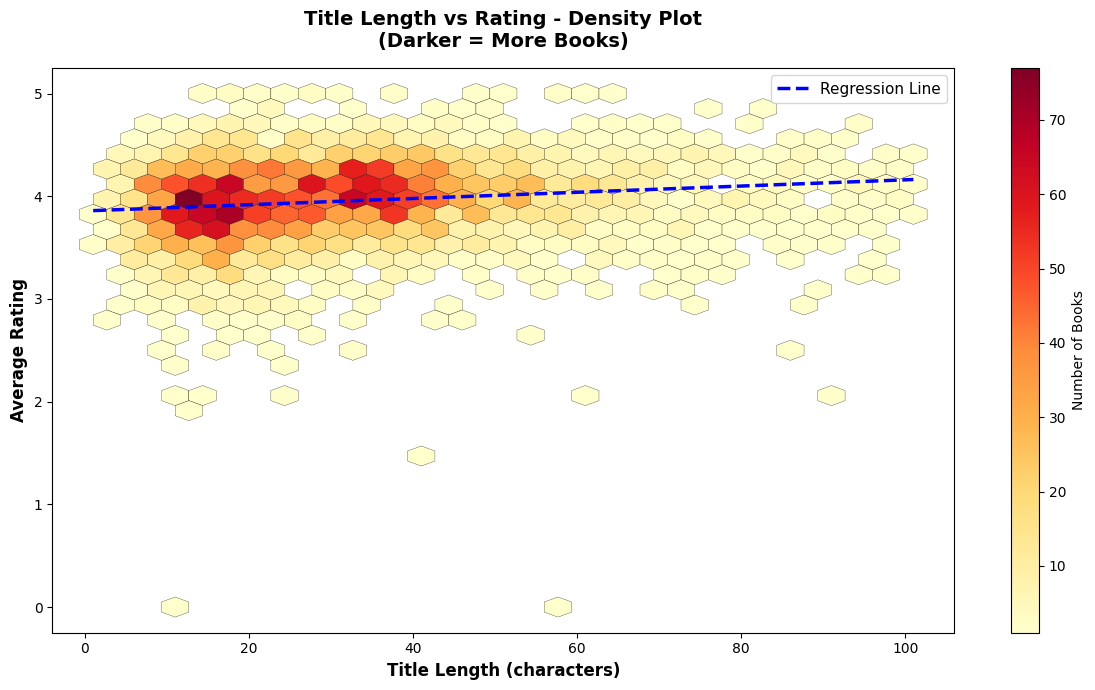

   ✅ Saved: figures/title_length_vs_rating_hexbin.png

🎉 VISUALIZATION COMPLETE!
📁 All figures saved to: figures/
   • figures/title_length_vs_rating_scatter.png
   • figures/title_length_category_ratings.png
   • figures/title_length_distributions.png
   • figures/title_length_vs_rating_hexbin.png

📊 KEY FINDINGS:
----------------------------------------------------------------------
1. Correlation (Characters): r = +0.1504 (p = 2.0638e-23)
2. Correlation (Words):      r = +0.1525 (p = 4.9129e-24)
3. Sample Size:              n = 4,348 books
4. Mean Title Length:        31.1 chars, 5.3 words
5. Mean Rating:              3.951

💡 INTERPRETATION:
   There is a WEAK positive correlation between title length and rating.
   Longer titles are slightly associated with higher ratings, but the effect is small.
   This relationship is STATISTICALLY SIGNIFICANT (p < 0.01).


In [15]:
# 📊 VISUALIZATIONS: Title Length vs Rating - Scatter Plots, Regression, & Distributions
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("🎨 CREATING TITLE LENGTH vs RATING VISUALIZATIONS")
print("=" * 70)

# Ensure figures directory exists
os.makedirs('figures', exist_ok=True)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

try:
    # Check if data is available from previous cell
    if 'title_rating_df' not in globals():
        raise NameError("Please run the previous cell first to load and prepare the data")
    
    df_viz = title_rating_df.copy()
    print(f"✅ Using {len(df_viz):,} books for visualization")
    
    # VISUALIZATION 1: Scatter Plot with Regression Line (Character Length)
    print("\n📊 Creating scatter plot: Title Length (chars) vs Rating...")
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Create scatter with some transparency
    scatter = ax.scatter(
        df_viz['title_len_chars'], 
        df_viz['rating_numeric'],
        alpha=0.3,
        s=20,
        c=df_viz['title_len_words'],
        cmap='viridis',
        edgecolors='none'
    )
    
    # Add regression line
    z = np.polyfit(df_viz['title_len_chars'], df_viz['rating_numeric'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_viz['title_len_chars'].min(), df_viz['title_len_chars'].max(), 100)
    ax.plot(x_line, p(x_line), "r--", linewidth=2, label=f'Regression: y={z[0]:.4f}x+{z[1]:.2f}')
    
    # Formatting
    ax.set_xlabel('Title Length (characters)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Rating', fontsize=12, fontweight='bold')
    ax.set_title('Book Title Length vs Average Rating\n(Color indicates word count)', 
                 fontsize=14, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)
    
    # Add correlation text box
    from scipy.stats import pearsonr
    r, p = pearsonr(df_viz['title_len_chars'], df_viz['rating_numeric'])
    textstr = f'Pearson r = {r:.4f}\np-value = {p:.4e}\nn = {len(df_viz):,}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Word Count', fontsize=10)
    
    plt.tight_layout()
    scatter_path = 'figures/title_length_vs_rating_scatter.png'
    plt.savefig(scatter_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"   ✅ Saved: {scatter_path}")
    
    # VISUALIZATION 2: Binned Bar Chart (Mean Rating by Length Category)
    print("\n📊 Creating bar chart: Mean rating by title-length category...")
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Calculate mean rating per category
    binned_data = df_viz.groupby('len_category', observed=True).agg({
        'rating_numeric': 'mean',
        'title': 'count'
    }).reset_index()
    binned_data.columns = ['Category', 'Mean Rating', 'Count']
    
    # Create bar chart
    bars = ax.bar(
        range(len(binned_data)),
        binned_data['Mean Rating'],
        color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'],
        edgecolor='black',
        linewidth=1.5
    )
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, binned_data['Count'])):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}\n(n={count:,})',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Formatting
    ax.set_xlabel('Title Length Category', fontsize=12, fontweight='bold')
    ax.set_ylabel('Mean Rating', fontsize=12, fontweight='bold')
    ax.set_title('Average Book Rating by Title Length Category', fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(range(len(binned_data)))
    ax.set_xticklabels(binned_data['Category'], rotation=15, ha='right')
    ax.set_ylim([binned_data['Mean Rating'].min() - 0.1, binned_data['Mean Rating'].max() + 0.15])
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    plt.tight_layout()
    bar_path = 'figures/title_length_category_ratings.png'
    plt.savefig(bar_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"   ✅ Saved: {bar_path}")
    
    # VISUALIZATION 3: Distribution Comparison (Histograms)
    print("\n📊 Creating distribution plots: Title length and rating distributions...")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # A) Title length (characters) distribution
    axes[0, 0].hist(df_viz['title_len_chars'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(df_viz['title_len_chars'].mean(), color='red', linestyle='--', 
                       linewidth=2, label=f"Mean: {df_viz['title_len_chars'].mean():.1f}")
    axes[0, 0].axvline(df_viz['title_len_chars'].median(), color='orange', linestyle='--',
                       linewidth=2, label=f"Median: {df_viz['title_len_chars'].median():.1f}")
    axes[0, 0].set_xlabel('Title Length (characters)', fontweight='bold')
    axes[0, 0].set_ylabel('Frequency', fontweight='bold')
    axes[0, 0].set_title('Distribution of Title Length (Characters)', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # B) Title length (words) distribution
    axes[0, 1].hist(df_viz['title_len_words'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(df_viz['title_len_words'].mean(), color='red', linestyle='--',
                       linewidth=2, label=f"Mean: {df_viz['title_len_words'].mean():.1f}")
    axes[0, 1].axvline(df_viz['title_len_words'].median(), color='orange', linestyle='--',
                       linewidth=2, label=f"Median: {df_viz['title_len_words'].median():.1f}")
    axes[0, 1].set_xlabel('Title Length (words)', fontweight='bold')
    axes[0, 1].set_ylabel('Frequency', fontweight='bold')
    axes[0, 1].set_title('Distribution of Title Length (Words)', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # C) Rating distribution
    axes[1, 0].hist(df_viz['rating_numeric'], bins=40, color='lightgreen', edgecolor='black', alpha=0.7)
    axes[1, 0].axvline(df_viz['rating_numeric'].mean(), color='red', linestyle='--',
                       linewidth=2, label=f"Mean: {df_viz['rating_numeric'].mean():.2f}")
    axes[1, 0].axvline(df_viz['rating_numeric'].median(), color='orange', linestyle='--',
                       linewidth=2, label=f"Median: {df_viz['rating_numeric'].median():.2f}")
    axes[1, 0].set_xlabel('Rating', fontweight='bold')
    axes[1, 0].set_ylabel('Frequency', fontweight='bold')
    axes[1, 0].set_title('Distribution of Book Ratings', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # D) Box plot: Rating by Length Category
    df_viz.boxplot(column='rating_numeric', by='len_category', ax=axes[1, 1])
    axes[1, 1].set_xlabel('Title Length Category', fontweight='bold')
    axes[1, 1].set_ylabel('Rating', fontweight='bold')
    axes[1, 1].set_title('Rating Distribution by Title Length', fontweight='bold')
    axes[1, 1].get_figure().suptitle('')  # Remove auto-generated title
    axes[1, 1].tick_params(axis='x', rotation=15)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    dist_path = 'figures/title_length_distributions.png'
    plt.savefig(dist_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"   ✅ Saved: {dist_path}")
    
    # VISUALIZATION 4: Hexbin Plot (Density visualization)
    print("\n📊 Creating hexbin density plot...")
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    hexbin = ax.hexbin(
        df_viz['title_len_chars'],
        df_viz['rating_numeric'],
        gridsize=30,
        cmap='YlOrRd',
        mincnt=1,
        edgecolors='black',
        linewidths=0.2
    )
    
    ax.set_xlabel('Title Length (characters)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Rating', fontsize=12, fontweight='bold')
    ax.set_title('Title Length vs Rating - Density Plot\n(Darker = More Books)', 
                 fontsize=14, fontweight='bold', pad=15)
    
    # Add colorbar
    cb = plt.colorbar(hexbin, ax=ax)
    cb.set_label('Number of Books', fontsize=10)
    
    # Add regression line
    z = np.polyfit(df_viz['title_len_chars'], df_viz['rating_numeric'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_viz['title_len_chars'].min(), df_viz['title_len_chars'].max(), 100)
    ax.plot(x_line, p(x_line), "b--", linewidth=2.5, label='Regression Line')
    ax.legend(loc='best', fontsize=11)
    
    plt.tight_layout()
    hexbin_path = 'figures/title_length_vs_rating_hexbin.png'
    plt.savefig(hexbin_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"   ✅ Saved: {hexbin_path}")
    
    # SUMMARY REPORT
    print("\n" + "=" * 70)
    print("🎉 VISUALIZATION COMPLETE!")
    print("=" * 70)
    print(f"📁 All figures saved to: figures/")
    print(f"   • {scatter_path}")
    print(f"   • {bar_path}")
    print(f"   • {dist_path}")
    print(f"   • {hexbin_path}")
    
    # KEY FINDINGS SUMMARY
    print("\n📊 KEY FINDINGS:")
    print("-" * 70)
    
    from scipy.stats import pearsonr
    r_chars, p_chars = pearsonr(df_viz['title_len_chars'], df_viz['rating_numeric'])
    r_words, p_words = pearsonr(df_viz['title_len_words'], df_viz['rating_numeric'])
    
    print(f"1. Correlation (Characters): r = {r_chars:+.4f} (p = {p_chars:.4e})")
    print(f"2. Correlation (Words):      r = {r_words:+.4f} (p = {p_words:.4e})")
    print(f"3. Sample Size:              n = {len(df_viz):,} books")
    print(f"4. Mean Title Length:        {df_viz['title_len_chars'].mean():.1f} chars, "
          f"{df_viz['title_len_words'].mean():.1f} words")
    print(f"5. Mean Rating:              {df_viz['rating_numeric'].mean():.3f}")
    
    # Interpretation
    print("\n💡 INTERPRETATION:")
    if abs(r_chars) < 0.1:
        conclusion = "There is NEGLIGIBLE correlation between title length and rating."
        implication = "Title length appears to have little to no relationship with book quality/satisfaction."
    elif abs(r_chars) < 0.3:
        direction = "positive" if r_chars > 0 else "negative"
        conclusion = f"There is a WEAK {direction} correlation between title length and rating."
        implication = f"Longer titles are slightly associated with {'higher' if r_chars > 0 else 'lower'} ratings, but the effect is small."
    else:
        direction = "positive" if r_chars > 0 else "negative"
        conclusion = f"There is a MODERATE {direction} correlation between title length and rating."
        implication = f"Title length shows a meaningful relationship with ratings - {'longer' if r_chars > 0 else 'shorter'} titles tend to receive {'higher' if r_chars > 0 else 'lower'} ratings."
    
    print(f"   {conclusion}")
    print(f"   {implication}")
    
    if p_chars < 0.01:
        print(f"   This relationship is STATISTICALLY SIGNIFICANT (p < 0.01).")
    else:
        print(f"   This relationship is NOT statistically significant (p = {p_chars:.4f}).")

except Exception as e:
    print(f"❌ Error creating visualizations: {e}")
    import traceback
    traceback.print_exc()

# Review Length Analysis

## Analyzing the length of review texts to understand user engagement patterns

This section explores:
- Distribution of review lengths (character count and word count)
- Statistical summary of review lengths
- Relationship between review length and ratings
- Categorization of reviews by length
- Visualization of length patterns

In [2]:
# 📝 REVIEW LENGTH ANALYSIS - Data Preparation & Statistics
from pymongo import MongoClient
import pandas as pd
import numpy as np
from scipy import stats
import json
import urllib.parse

print("=" * 70)
print("📝 REVIEW LENGTH ANALYSIS")
print("=" * 70)

try:
    # STEP 1: Connect to MongoDB
    print("\n🔌 STEP 1: Connecting to MongoDB...")
    
    with open('credentials_mongodb.json') as f:
        login = json.load(f)
    
    username = login['username']
    password = urllib.parse.quote(login['password'])
    host = login['host']
    url = "mongodb+srv://{}:{}@{}/?retryWrites=true&w=majority".format(username, password, host)
    
    client = MongoClient(url)
    database = client['goodreads']
    collection = database['reviews']
    
    print("   ✅ Connected to MongoDB Atlas")
    
    # STEP 2: Fetch reviews with review_text and rating
    print("\n📚 STEP 2: Fetching reviews from database...")
    
    reviews_cursor = collection.find(
        {
            'review_text': {'$exists': True, '$ne': ''},
            'rating': {'$exists': True, '$type': 'number'}
        },
        {
            '_id': 0,
            'review_text': 1,
            'rating': 1,
            'book_title': 1
        }
    )
    
    reviews = list(reviews_cursor)
    print(f"   ✅ Fetched {len(reviews):,} reviews with valid text and ratings")
    
    # STEP 3: Create DataFrame and calculate review lengths
    print("\n🔧 STEP 3: Calculating review lengths...")
    
    df = pd.DataFrame(reviews)
    
    # Calculate character length (including spaces and punctuation)
    df['review_len_chars'] = df['review_text'].astype(str).str.len()
    
    # Calculate word count
    df['review_len_words'] = df['review_text'].astype(str).str.split().apply(len)
    
    # Ensure rating is numeric
    df['rating_numeric'] = pd.to_numeric(df['rating'], errors='coerce')
    
    # STEP 4: Data Cleaning
    print("\n🧹 STEP 4: Cleaning data...")
    print(f"   Before cleaning: {len(df):,} rows")
    
    # Remove rows with missing ratings
    df_clean = df.dropna(subset=['rating_numeric']).copy()
    
    # Remove extreme outliers (keep 99th percentile)
    char_99 = df_clean['review_len_chars'].quantile(0.99)
    df_clean = df_clean[df_clean['review_len_chars'] <= char_99]
    
    # Remove zero-length reviews
    df_clean = df_clean[df_clean['review_len_chars'] > 0]
    
    print(f"   After cleaning: {len(df_clean):,} rows")
    print(f"   Removed: {len(df) - len(df_clean):,} rows ({(len(df) - len(df_clean))/len(df)*100:.1f}%)")
    
    # STEP 5: Descriptive Statistics
    print("\n📊 STEP 5: Descriptive statistics")
    print("-" * 70)
    
    stats_summary = pd.DataFrame({
        'Metric': ['Review Length (chars)', 'Review Length (words)', 'Rating'],
        'Mean': [
            df_clean['review_len_chars'].mean(),
            df_clean['review_len_words'].mean(),
            df_clean['rating_numeric'].mean()
        ],
        'Median': [
            df_clean['review_len_chars'].median(),
            df_clean['review_len_words'].median(),
            df_clean['rating_numeric'].median()
        ],
        'Std Dev': [
            df_clean['review_len_chars'].std(),
            df_clean['review_len_words'].std(),
            df_clean['rating_numeric'].std()
        ],
        'Min': [
            df_clean['review_len_chars'].min(),
            df_clean['review_len_words'].min(),
            df_clean['rating_numeric'].min()
        ],
        'Max': [
            df_clean['review_len_chars'].max(),
            df_clean['review_len_words'].max(),
            df_clean['rating_numeric'].max()
        ]
    })
    
    # Format numbers for display
    for col in ['Mean', 'Median', 'Std Dev']:
        stats_summary[col] = stats_summary[col].apply(lambda x: f"{x:.2f}")
    for col in ['Min', 'Max']:
        stats_summary[col] = stats_summary[col].apply(lambda x: f"{x:.1f}")
    
    print(stats_summary.to_string(index=False))
    
    # STEP 6: Categorize reviews by length
    print("\n📦 STEP 6: Categorizing reviews by length")
    print("-" * 70)
    
    df_clean['length_category'] = pd.cut(
        df_clean['review_len_chars'],
        bins=[0, 50, 100, 200, 500, 10000],
        labels=['Very Short (1-50)', 'Short (51-100)', 'Medium (101-200)', 'Long (201-500)', 'Very Long (500+)']
    )
    
    category_stats = df_clean.groupby('length_category', observed=True).agg({
        'rating_numeric': ['mean', 'median', 'std', 'count']
    }).round(3)
    
    category_stats.columns = ['Mean Rating', 'Median Rating', 'Std Dev', 'Count']
    category_stats = category_stats.reset_index()
    category_stats.columns = ['Length Category', 'Mean Rating', 'Median Rating', 'Std Dev', 'Count']
    category_stats['Percentage'] = (category_stats['Count'] / len(df_clean) * 100).round(2)
    
    print(category_stats.to_string(index=False))
    
    # STEP 7: Correlation Analysis
    print("\n📈 STEP 7: Correlation tests (Review Length vs Rating)")
    print("-" * 70)
    
    from scipy.stats import pearsonr, spearmanr
    
    x_chars = df_clean['review_len_chars'].values
    x_words = df_clean['review_len_words'].values
    y_rating = df_clean['rating_numeric'].values
    
    n_samples = len(df_clean)
    
    # A) Character length vs Rating
    pearson_r_chars, pearson_p_chars = pearsonr(x_chars, y_rating)
    spearman_r_chars, spearman_p_chars = spearmanr(x_chars, y_rating)
    
    print("📏 A) Review Length (characters) vs Rating:")
    print(f"   Sample size: {n_samples:,}")
    print(f"   Pearson correlation:  r = {pearson_r_chars:+.4f}, p-value = {pearson_p_chars:.4e}")
    print(f"   Spearman correlation: ρ = {spearman_r_chars:+.4f}, p-value = {spearman_p_chars:.4e}")
    
    # Interpretation
    if abs(pearson_r_chars) < 0.1:
        strength = "negligible"
    elif abs(pearson_r_chars) < 0.3:
        strength = "weak"
    elif abs(pearson_r_chars) < 0.5:
        strength = "moderate"
    else:
        strength = "strong"
    
    direction = "positive" if pearson_r_chars > 0 else "negative"
    significance = "statistically significant" if pearson_p_chars < 0.01 else "not significant"
    
    print(f"   Interpretation: {strength.capitalize()} {direction} correlation, {significance}")
    
    # B) Word count vs Rating
    pearson_r_words, pearson_p_words = pearsonr(x_words, y_rating)
    spearman_r_words, spearman_p_words = spearmanr(x_words, y_rating)
    
    print("\n📝 B) Review Length (words) vs Rating:")
    print(f"   Sample size: {n_samples:,}")
    print(f"   Pearson correlation:  r = {pearson_r_words:+.4f}, p-value = {pearson_p_words:.4e}")
    print(f"   Spearman correlation: ρ = {spearman_r_words:+.4f}, p-value = {spearman_p_words:.4e}")
    
    # Save cleaned data for visualization
    print(f"\n✅ Data preparation complete - {len(df_clean):,} reviews ready for visualization")
    
    # Store in global scope for next cell
    review_length_df = df_clean.copy()
    
except Exception as e:
    print(f"❌ Error during analysis: {e}")
    import traceback
    traceback.print_exc()
finally:
    if 'client' in locals():
        client.close()
        print("\n🔌 MongoDB connection closed")

📝 REVIEW LENGTH ANALYSIS

🔌 STEP 1: Connecting to MongoDB...
   ✅ Connected to MongoDB Atlas

📚 STEP 2: Fetching reviews from database...
   ✅ Fetched 8,125 reviews with valid text and ratings

🔧 STEP 3: Calculating review lengths...

🧹 STEP 4: Cleaning data...
   Before cleaning: 8,125 rows
   After cleaning: 8,043 rows
   Removed: 82 rows (1.0%)

📊 STEP 5: Descriptive statistics
----------------------------------------------------------------------
               Metric   Mean Median Std Dev Min    Max
Review Length (chars) 670.15 375.00  783.35 1.0 4600.0
Review Length (words) 119.23  68.00  138.38 1.0  845.0
               Rating   3.80   4.00    1.24 0.0    5.0

📦 STEP 6: Categorizing reviews by length
----------------------------------------------------------------------
  Length Category  Mean Rating  Median Rating  Std Dev  Count  Percentage
Very Short (1-50)        3.499            4.0    1.481    720        8.95
   Short (51-100)        3.634            4.0    1.342    703   

🎨 CREATING REVIEW LENGTH VISUALIZATIONS
✅ Using 8,043 reviews for visualization

📊 1. Creating review length distribution histogram...


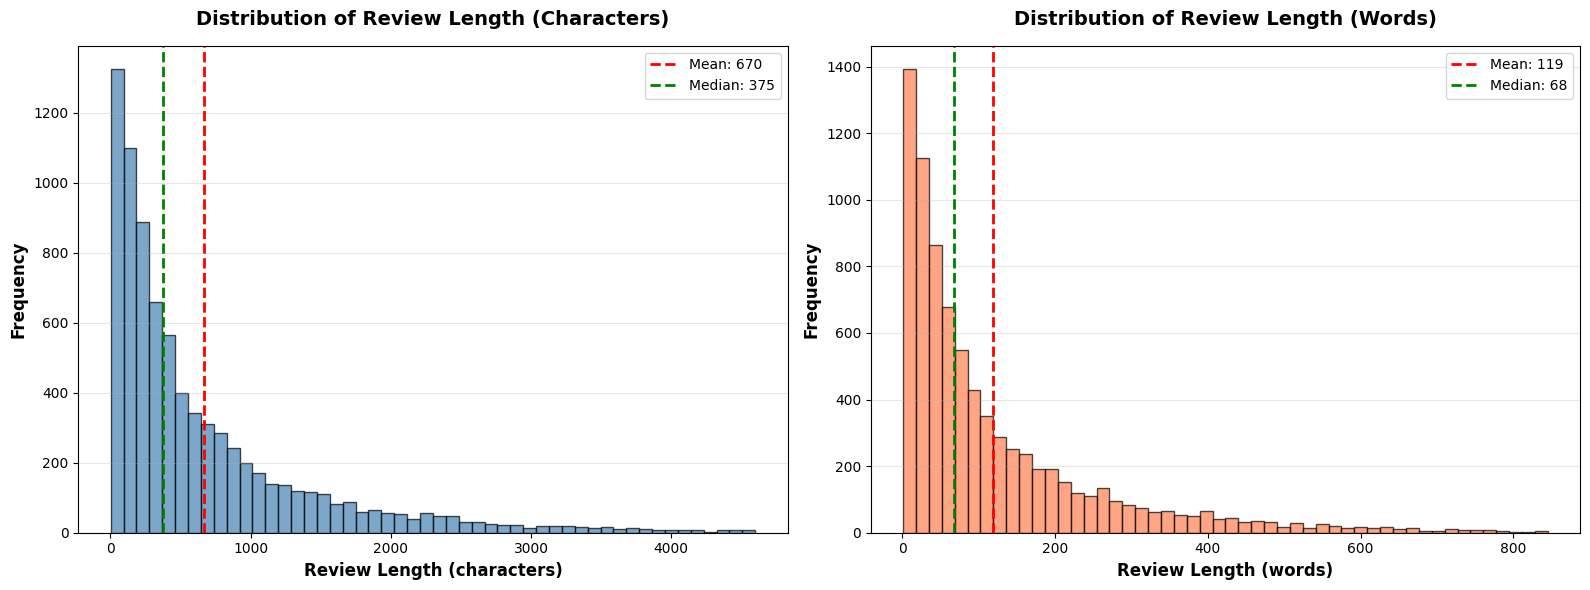

   ✅ Saved: figures/review_length_distribution.png

📈 2. Creating review length vs rating scatter plot...


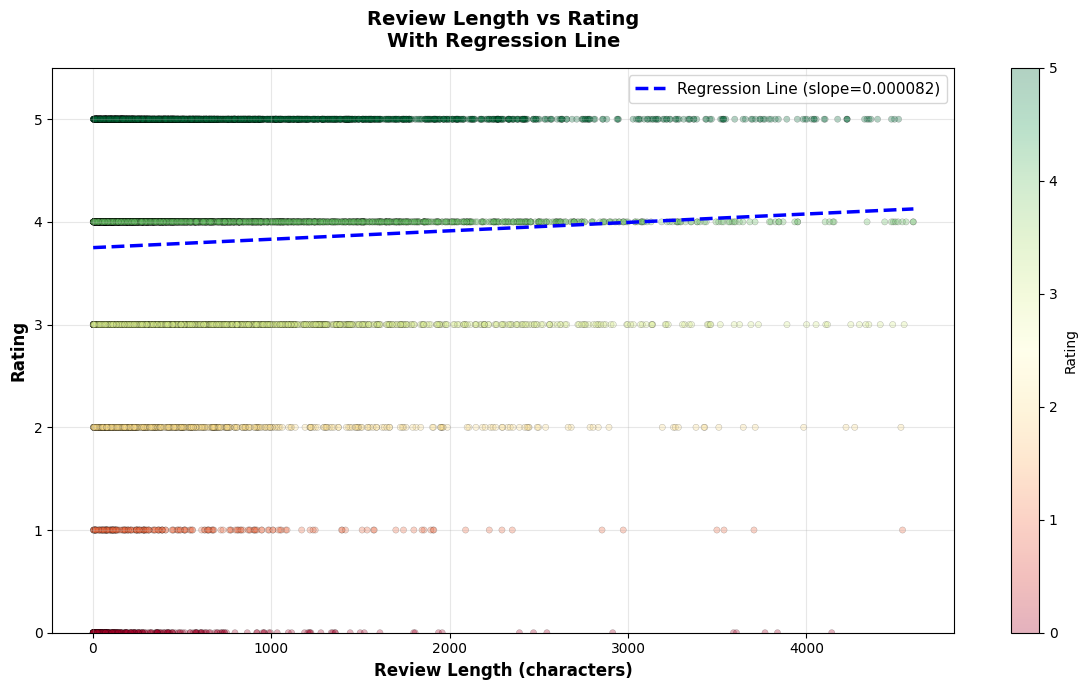

   ✅ Saved: figures/review_length_vs_rating_scatter.png

📊 3. Creating review length category distribution...


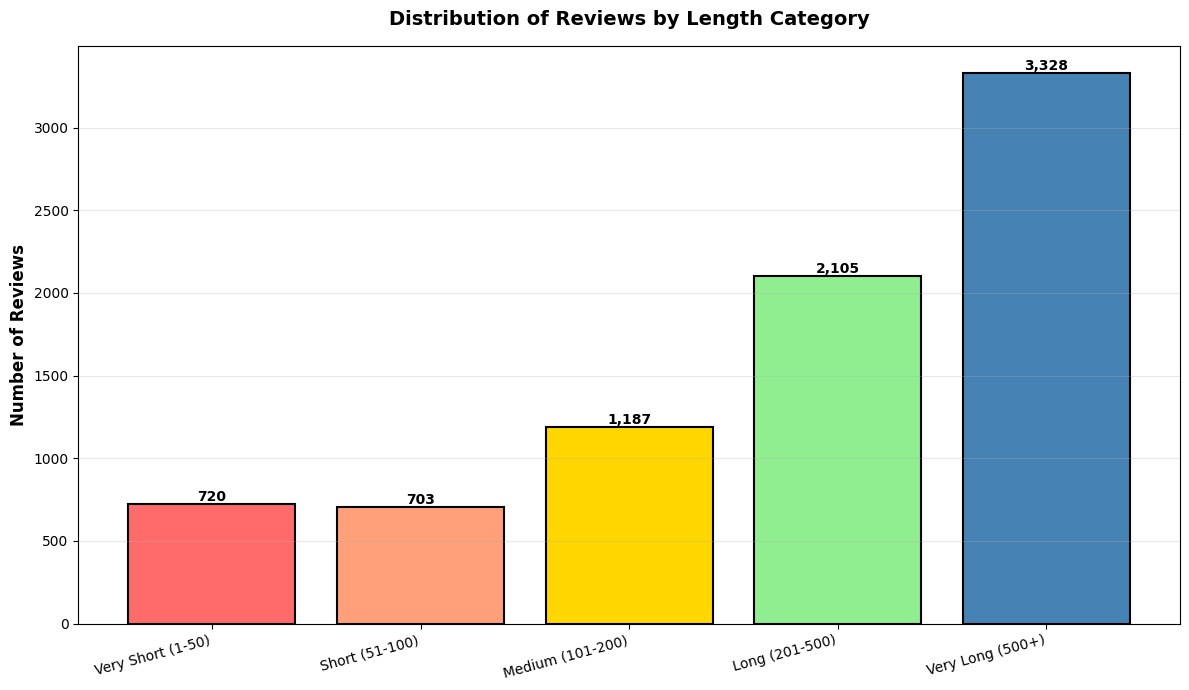

   ✅ Saved: figures/review_length_categories_bar.png

📦 4. Creating rating distribution by length category...


/var/folders/7y/q62w0hd56b36skqwnrwmv3fc0000gn/T/ipykernel_55862/3392602855.py:132: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


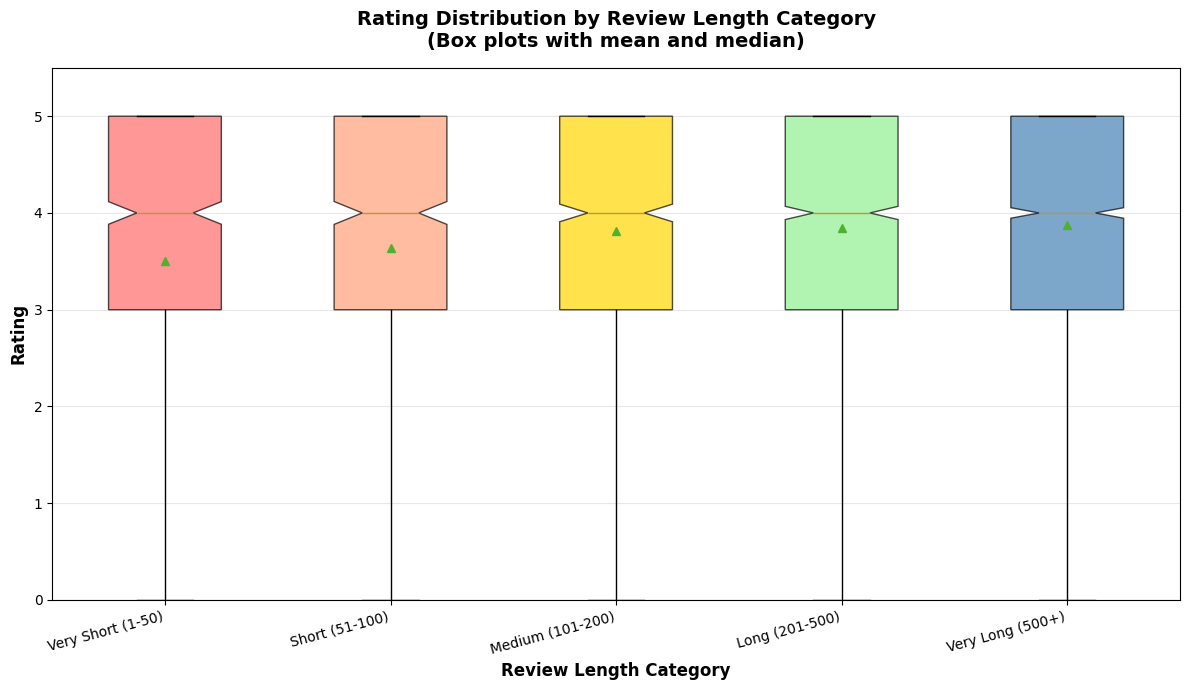

   ✅ Saved: figures/rating_by_length_category_boxplot.png

🎉 VISUALIZATION COMPLETE!
📁 All figures saved to: figures/
   • figures/review_length_distribution.png
   • figures/review_length_vs_rating_scatter.png
   • figures/review_length_categories_bar.png
   • figures/rating_by_length_category_boxplot.png

📊 KEY FINDINGS:
----------------------------------------------------------------------
1. Correlation (Characters): r = +0.0519 (p = 3.1824e-06)
2. Correlation (Words):      r = +0.0546 (p = 9.6090e-07)
3. Sample Size:              n = 8,043 reviews
4. Mean Review Length:       670.1 chars, 119.2 words
5. Median Review Length:     375 chars, 68 words
6. Mean Rating:              3.804
7. Most Common Length:       Very Long (500+) (41.4% of reviews)

💡 INTERPRETATION:
   There is NEGLIGIBLE correlation between review length and rating.
   Review length does not appear to influence rating behavior.
   This relationship is STATISTICALLY SIGNIFICANT (p < 0.01).


In [3]:
# 📊 VISUALIZATIONS: Review Length Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("🎨 CREATING REVIEW LENGTH VISUALIZATIONS")
print("=" * 70)

# Ensure figures directory exists
os.makedirs('figures', exist_ok=True)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

try:
    # Check if data is available from previous cell
    if 'review_length_df' not in globals():
        raise NameError("Please run the previous cell first to load and prepare the data")
    
    df_viz = review_length_df.copy()
    print(f"✅ Using {len(df_viz):,} reviews for visualization")
    
    # VISUALIZATION 1: Distribution of Review Lengths (Histogram)
    print("\n📊 1. Creating review length distribution histogram...")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Character length distribution
    ax1 = axes[0]
    ax1.hist(df_viz['review_len_chars'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax1.axvline(df_viz['review_len_chars'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_viz["review_len_chars"].mean():.0f}')
    ax1.axvline(df_viz['review_len_chars'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_viz["review_len_chars"].median():.0f}')
    ax1.set_xlabel('Review Length (characters)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax1.set_title('Distribution of Review Length (Characters)', fontsize=14, fontweight='bold', pad=15)
    ax1.legend(fontsize=10)
    ax1.grid(axis='y', alpha=0.3)
    
    # Word count distribution
    ax2 = axes[1]
    ax2.hist(df_viz['review_len_words'], bins=50, color='coral', edgecolor='black', alpha=0.7)
    ax2.axvline(df_viz['review_len_words'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_viz["review_len_words"].mean():.0f}')
    ax2.axvline(df_viz['review_len_words'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_viz["review_len_words"].median():.0f}')
    ax2.set_xlabel('Review Length (words)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax2.set_title('Distribution of Review Length (Words)', fontsize=14, fontweight='bold', pad=15)
    ax2.legend(fontsize=10)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    hist_path = 'figures/review_length_distribution.png'
    plt.savefig(hist_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"   ✅ Saved: {hist_path}")
    
    # VISUALIZATION 2: Review Length vs Rating (Scatter Plot)
    print("\n📈 2. Creating review length vs rating scatter plot...")
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Create scatter with some transparency
    scatter = ax.scatter(
        df_viz['review_len_chars'],
        df_viz['rating_numeric'],
        alpha=0.3,
        s=20,
        c=df_viz['rating_numeric'],
        cmap='RdYlGn',
        edgecolors='black',
        linewidth=0.3
    )
    
    # Add regression line
    z = np.polyfit(df_viz['review_len_chars'], df_viz['rating_numeric'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_viz['review_len_chars'].min(), df_viz['review_len_chars'].max(), 100)
    ax.plot(x_line, p(x_line), "b--", linewidth=2.5, label=f'Regression Line (slope={z[0]:.6f})')
    
    # Formatting
    ax.set_xlabel('Review Length (characters)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Rating', fontsize=12, fontweight='bold')
    ax.set_title('Review Length vs Rating\nWith Regression Line', fontsize=14, fontweight='bold', pad=15)
    ax.set_ylim(0, 5.5)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=11)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Rating', fontsize=10)
    
    plt.tight_layout()
    scatter_path = 'figures/review_length_vs_rating_scatter.png'
    plt.savefig(scatter_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"   ✅ Saved: {scatter_path}")
    
    # VISUALIZATION 3: Review Length Categories (Bar Chart)
    print("\n📊 3. Creating review length category distribution...")
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    category_counts = df_viz['length_category'].value_counts().sort_index()
    colors = ['#FF6B6B', '#FFA07A', '#FFD700', '#90EE90', '#4682B4']
    
    bars = ax.bar(range(len(category_counts)), category_counts.values, color=colors, edgecolor='black', linewidth=1.5)
    ax.set_xticks(range(len(category_counts)))
    ax.set_xticklabels(category_counts.index, rotation=15, ha='right')
    ax.set_ylabel('Number of Reviews', fontsize=12, fontweight='bold')
    ax.set_title('Distribution of Reviews by Length Category', fontsize=14, fontweight='bold', pad=15)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    bar_path = 'figures/review_length_categories_bar.png'
    plt.savefig(bar_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"   ✅ Saved: {bar_path}")
    
    # VISUALIZATION 4: Average Rating by Length Category (Box Plot)
    print("\n📦 4. Creating rating distribution by length category...")
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Create box plot
    bp = ax.boxplot(
        [df_viz[df_viz['length_category'] == cat]['rating_numeric'].values 
         for cat in df_viz['length_category'].cat.categories],
        labels=df_viz['length_category'].cat.categories,
        patch_artist=True,
        notch=True,
        showmeans=True
    )
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_xlabel('Review Length Category', fontsize=12, fontweight='bold')
    ax.set_ylabel('Rating', fontsize=12, fontweight='bold')
    ax.set_title('Rating Distribution by Review Length Category\n(Box plots with mean and median)', 
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xticklabels(df_viz['length_category'].cat.categories, rotation=15, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 5.5)
    
    plt.tight_layout()
    box_path = 'figures/rating_by_length_category_boxplot.png'
    plt.savefig(box_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"   ✅ Saved: {box_path}")
    
    # SUMMARY REPORT
    print("\n" + "=" * 70)
    print("🎉 VISUALIZATION COMPLETE!")
    print("=" * 70)
    print(f"📁 All figures saved to: figures/")
    print(f"   • {hist_path}")
    print(f"   • {scatter_path}")
    print(f"   • {bar_path}")
    print(f"   • {box_path}")
    
    # KEY FINDINGS SUMMARY
    print("\n📊 KEY FINDINGS:")
    print("-" * 70)
    
    from scipy.stats import pearsonr
    r_chars, p_chars = pearsonr(df_viz['review_len_chars'], df_viz['rating_numeric'])
    r_words, p_words = pearsonr(df_viz['review_len_words'], df_viz['rating_numeric'])
    
    print(f"1. Correlation (Characters): r = {r_chars:+.4f} (p = {p_chars:.4e})")
    print(f"2. Correlation (Words):      r = {r_words:+.4f} (p = {p_words:.4e})")
    print(f"3. Sample Size:              n = {len(df_viz):,} reviews")
    print(f"4. Mean Review Length:       {df_viz['review_len_chars'].mean():.1f} chars, "
          f"{df_viz['review_len_words'].mean():.1f} words")
    print(f"5. Median Review Length:     {df_viz['review_len_chars'].median():.0f} chars, "
          f"{df_viz['review_len_words'].median():.0f} words")
    print(f"6. Mean Rating:              {df_viz['rating_numeric'].mean():.3f}")
    
    # Most common category
    most_common = df_viz['length_category'].value_counts().idxmax()
    most_common_pct = (df_viz['length_category'].value_counts().max() / len(df_viz)) * 100
    print(f"7. Most Common Length:       {most_common} ({most_common_pct:.1f}% of reviews)")
    
    # Interpretation
    print("\n💡 INTERPRETATION:")
    if abs(r_chars) < 0.1:
        conclusion = "There is NEGLIGIBLE correlation between review length and rating."
        implication = "Review length does not appear to influence rating behavior."
    elif abs(r_chars) < 0.3:
        direction = "positive" if r_chars > 0 else "negative"
        conclusion = f"There is a WEAK {direction} correlation between review length and rating."
        implication = f"Longer reviews are slightly associated with {'higher' if r_chars > 0 else 'lower'} ratings, but the effect is small."
    else:
        direction = "positive" if r_chars > 0 else "negative"
        conclusion = f"There is a MODERATE/STRONG {direction} correlation between review length and rating."
        implication = f"Review length shows a meaningful relationship with ratings - {'longer' if r_chars > 0 else 'shorter'} reviews tend to have {'higher' if r_chars > 0 else 'lower'} ratings."
    
    print(f"   {conclusion}")
    print(f"   {implication}")
    
    if p_chars < 0.01:
        print(f"   This relationship is STATISTICALLY SIGNIFICANT (p < 0.01).")
    else:
        print(f"   This relationship is NOT statistically significant (p = {p_chars:.4f}).")

except Exception as e:
    print(f"❌ Error creating visualizations: {e}")
    import traceback
    traceback.print_exc()